# Introduction to Python  

## Natural Language Processing - Exploratory Data Analysis (EDA)

In [1]:
!pip install -U -q pip nltk gensim wordcloud textract textstat textblob spacy pyldavis goose3 numpy

In [2]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import textstat
import textblob

from IPython.core.display import Image
%matplotlib inline

/home/rsouza/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify a

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /home/rsouza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rsouza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rsouza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rsouza/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/rsouza/nltk_data...
[nltk_data]   Pack

True

Specifying the path to the files

In [4]:
datapath = "../Data/"
outputs = "../Data/"

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Examining files and folders

In [5]:
onlydirs = [f for f in os.listdir(datapath) if os.path.isdir(os.path.join(datapath,f)) and not f.startswith('.')]
onlydirs

['TXT', 'Figs', 'Oplexicon_v3.0', 'EDA', 'CSV', 'Texts']

In [6]:
corpuspath = os.path.join(datapath, 'Texts')
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- abcnews-date-text.csv
2 -- Possibly_Misclassified_Cables_Review.xlsx
3 -- RobertFrost_Poetry.pdf
4 -- AldousHuxley_bravenewworld.pdf
5 -- MarcelProust_EmBuscadoTempoPerdido.pdf
6 -- ARTIGOS-RBE-COM-RESUMO.xlsx


## Example 1

Loading first corpus:

In [7]:
df = pd.read_excel(os.path.join(corpuspath, 'Possibly_Misclassified_Cables_Review.xlsx'))
df.head()

/usr/local/lib/python3.8/dist-packages/openpyxl/compat/numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


,id,link to orig. doc,Prob_Classified,Prob_Unclassified,Odds,date,origclass,subject
0,1975BANGKO06331,NaN,0.499997,0.500003,0.999987,1975-04-14,CONFIDENTIAL,gkr pl 480 rice in pipeline
1,1976MOSCOW15759,NaN,0.499995,0.500005,0.999980,1976-10-06,CONFIDENTIAL,oecd east-west initiative suggested addition
2,1974BOGOTA01772,NaN,0.499951,0.500049,0.999804,1974-02-28,CONFIDENTIAL,dea special agent positions
3,1975STATE034056,NaN,0.499901,0.500099,0.999605,1975-02-14,CONFIDENTIAL,homeporting destroyer tender in naples
4,1973STATE241960,NaN,0.499896,0.500104,0.999585,1973-12-11,CONFIDENTIAL,president ceausescu visit


In [8]:
df.columns

Index(['id', 'link to orig. doc', 'Prob_Classified', 'Prob_Unclassified',
       'Odds', 'date', 'origclass', 'subject'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16927 entries, 0 to 16926
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 16927 non-null  object        
 1   link to orig. doc  0 non-null      float64       
 2   Prob_Classified    16927 non-null  float64       
 3   Prob_Unclassified  16927 non-null  float64       
 4   Odds               16927 non-null  float64       
 5   date               16927 non-null  datetime64[ns]
 6   origclass          16927 non-null  object        
 7   subject            16920 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.0+ MB


In [10]:
df.dropna(axis='rows', subset=["subject"], inplace=True)

In [11]:
df['subject'] += " "

In [12]:
texts = df['subject'].sum()
texts[0:1000]

'gkr pl 480 rice in pipeline oecd east-west initiative suggested addition dea special agent positions homeporting destroyer tender in naples president ceausescu visit opec price decision letter from president carter to president eanes press guidance for npw visit orit boycott pinochet to address labor rally visit of belgian foreign minister to rwanda penney throws in towel srv participation in 20th session escap committee on trade changes in honduran economic leadership vietnamese refugees in thailand tarapur us-ussr housing agreement pre-departure briefing for u.s executive secretary 10.00 civair klm frequencies nkomo-callaghan meeting british hicom informs us that nkomo will depart lusaka night of july 26 for london will meet owens-illinois case annual congressional report on security assistance planned study in u.s by large group of libyans sponsored by libyan atomic energy commission demirel comments on cyprus los resumed seventh session the continental shelf international steel ag

In [13]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')

In [14]:
stop_en.extend(['-','', '”'])

In [15]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stop_en]
list_words[0:20]

['gkr',
 'pl',
 '480',
 'rice',
 'pipeline',
 'oecd',
 'east-west',
 'initiative',
 'suggested',
 'addition',
 'dea',
 'special',
 'agent',
 'positions',
 'homeporting',
 'destroyer',
 'tender',
 'naples',
 'president',
 'ceausescu']

In [16]:
freqdist = Counter(list_words)

In [17]:
freqdist.most_common(20)

[('visit', 1017),
 ('meeting', 791),
 ('us', 622),
 ('press', 581),
 ('request', 577),
 ('conference', 526),
 ('u.s', 486),
 ('minister', 482),
 ('president', 470),
 ('secretary', 446),
 ('foreign', 439),
 ('committee', 436),
 ('agreement', 395),
 ('ambassador', 364),
 ('report', 355),
 ('assistance', 334),
 ('new', 316),
 ('program', 305),
 ('group', 278),
 ('statement', 262)]

In [18]:
cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

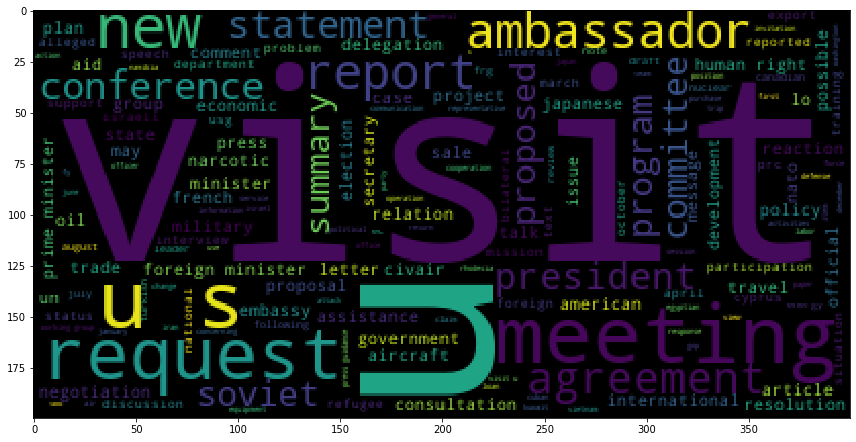

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

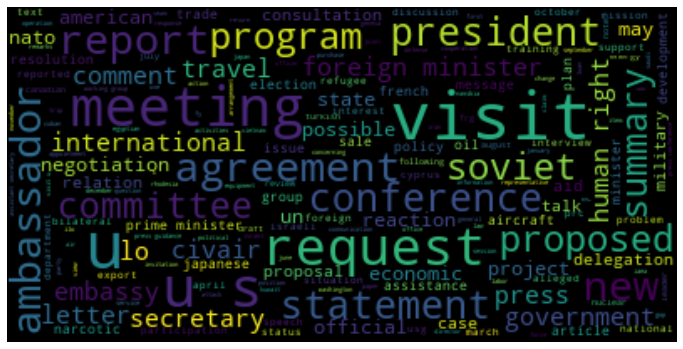

In [20]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

## Example 2

In [22]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- abcnews-date-text.csv
2 -- Possibly_Misclassified_Cables_Review.xlsx
3 -- RobertFrost_Poetry.pdf
4 -- AldousHuxley_bravenewworld.pdf
5 -- MarcelProust_EmBuscadoTempoPerdido.pdf
6 -- ARTIGOS-RBE-COM-RESUMO.xlsx


In [23]:
raw_texts = ''

for filename in [f for f in onlyfiles if f.endswith('pdf')]:
    print(filename)
    text = textract.process(os.path.join(corpuspath,filename)).decode('utf-8')
    print('\nTexto:\n', text[0:50])
    raw_texts += '\n'+ text
    break

RobertFrost_Poetry.pdf

Texto:
 Classic Poetry Series

Robert Frost
- poems -

Pub


In [24]:
print(len(raw_texts))

115896


Cleaning and homogenizing texts:

In [25]:
cleaned_texts = raw_texts.lower()
cleaned_texts = re.sub(' +',' ', cleaned_texts) #Remove multiple spaces
cleaned_texts = re.sub(r'\n\s*\n', '\n', cleaned_texts)

In [26]:
print(len(cleaned_texts))

115381


In [27]:
print(cleaned_texts[0:200])


classic poetry series
robert frost
- poems -
publication date:
2004
publisher:
poemhunter.com - the world's poetry archive
"in white": frost's early version of design
a dented spider like a snow dro


In [28]:
stop_en.extend(['poetry','archive', "world's", "www.poemhunter.com", 'com', 'poemhunter', 'www', "robert", "frost"])

In [29]:
list_words = cleaned_texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation+'“”’') for l in list_words]
list_words = [l for l in list_words if l not in stop_en]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('one', 108),
 ('like', 83),
 ('make', 54),
 ('see', 52),
 ('know', 50),
 ('go', 49),
 ('could', 48),
 ('come', 48),
 ('us', 45),
 ('back', 45),
 ('say', 44),
 ('way', 44),
 ('day', 40),
 ('thought', 37),
 ('though', 37),
 ('still', 37),
 ('love', 37),
 ('night', 36),
 ('said', 35),
 ('would', 35)]

Finding ocurrences of an expression:

In [30]:
expression = 'life'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_texts.find(expression,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print('The expression is found {} times'.format(len(positions)))
print(positions)

The expression is found 18 times
[269, 14235, 24431, 26472, 43932, 47042, 48697, 59555, 62163, 63776, 86686, 94454, 95403, 106842, 107777, 112063, 113044, 114310]


Understanding contexts in which words occur:

In [31]:
# Pure Python
window = 18
for position in positions[0:20]:
    print(cleaned_texts[position - window:position + window + len(expression)].strip())

a white piece of lifeless satin cloth s
mmodate her young life to his.
that was
word i was in my life alone,
word i had
nsiderations,
and life is too much like
their way back to life
and living people
a white piece of lifeless satin cloth s
e at all.
late in life i have come on fe
ently on with our life,
and look elsewhe
as if to keep
the life from spilling. th
as if to keep
the life from spilling. th
his is a pleasant life
to set your breas
112
the span of life
the old dog barks
cope
to satisfy a lifelong curiosity
abo
hance i missed in life
through some dela
hance i missed in life
through some dela
give some sign of life? because you can'
the blows that a life of self-control
s
tspread feet,
the life of muscles rockin


In [32]:
# Using NLTK

tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_texts)
tokens = [token for token in tokens if token not in stop_en]
nltk_text = nltk.Text(tokens)

nltk_text.concordance(expression.lower(), width=120, lines=20)

Displaying 15 of 15 matches:
ame , bride , help take care creature , accommodate young life . marrying father meant . lie hear love things made dread
nown : word house alone somehow must gotten abroad , word life alone , word one left god . . . world ' 25 birches see bi
r birches . dream going back . ' ' weary considerations , life much like pathless wood face burns tickles cobwebs broken
following grave , one , minds turned making best way back life living people , things understand . world ' evil . ' grie
e enough . giant trees bloom small might well none . late life come fern . lichens due turn . bade men tell brief , fair
 nothing ever happens , harm done . may well go patiently life , look elsewhere stars moon sun shocks changes need keep 
laugh , swung toward holding hand half appeal , half keep life spilling . boy saw since old enough know , big boy man ' 
laugh , swung toward holding hand half appeal , half keep life spilling . boy saw since old enough know , big boy man ' 
es 

Words that occur in similar contexts than the query expression:

In [33]:
nltk_text.similar(expression)

house


[Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
http://www.nltk.org/howto/collocations.html  

In [34]:
nltk_text.collocation_list(num=20, window_size=20)

[('rose', 'rose'),
 ('white', 'cloth'),
 ('white', 'satin'),
 ('rose', 'suppose'),
 ('snarled', 'rattled'),
 ('kindred', 'design'),
 ('spider', 'white'),
 ('white', 'piece'),
 ('white', 'white'),
 ('height', 'design'),
 ('poet', 'meant'),
 ('lance', 'lies'),
 ('next', 'crop'),
 ('soldier', 'meant'),
 ('white', 'heal'),
 ('white', 'moth'),
 ('load', 'thousand'),
 ('design', 'aright'),
 ('thesis', 'design'),
 ('sleep', 'sleep')]

Below we are using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [35]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

In [36]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 50.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

In [37]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

In [38]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq, 50.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

In [39]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('.', '.', 'world', "'"), 131),
 (('.', '.', '.', 'world'), 105),
 (('?', '.', '.', 'world'), 9),
 (('sleep', '.', '.', '.'), 4),
 ((',', "'", ',', "'"), 4),
 (('white', 'heal', ',', 'holding'), 3),
 (('heal', ',', 'holding', 'moth'), 3),
 ((',', 'holding', 'moth', 'like'), 3),
 (('holding', 'moth', 'like', 'white'), 3),
 (('moth', 'like', 'white', 'piece'), 3),
 (('like', 'ingredients', 'witches', "'"), 3),
 (('ingredients', 'witches', "'", 'broth'), 3),
 (('spider', ',', 'flower', 'like'), 3),
 ((',', 'flower', 'like', 'froth'), 3),
 (('flower', 'like', 'froth', ','), 3),
 (('carried', 'like', 'paper', 'kite'), 3),
 (('like', 'paper', 'kite', '.'), 3),
 (('paper', 'kite', '.', 'flower'), 3),
 (('kite', '.', 'flower', 'white'), 3),
 (('.', 'flower', 'white', ','), 3)]

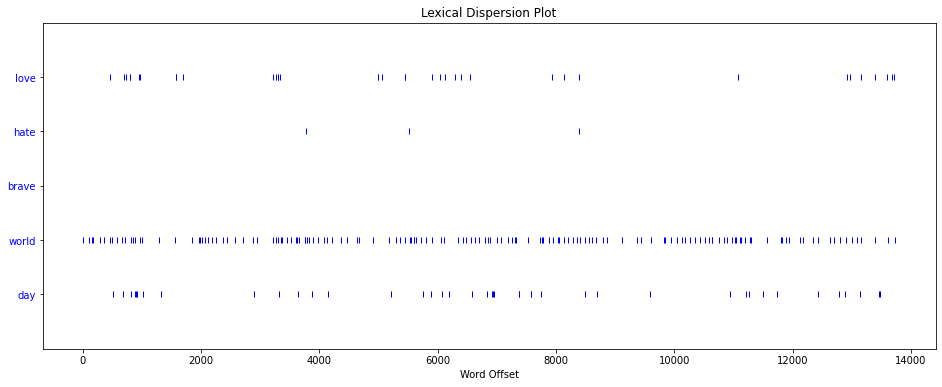

In [40]:
dispersion_words = ['love', 'hate', 'brave','world', 'day']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

Different ways to visualize frequent words:

In [41]:
freqdist.most_common(100)

[('one', 108),
 ('like', 83),
 ('make', 54),
 ('see', 52),
 ('know', 50),
 ('go', 49),
 ('could', 48),
 ('come', 48),
 ('us', 45),
 ('back', 45),
 ('say', 44),
 ('way', 44),
 ('day', 40),
 ('thought', 37),
 ('though', 37),
 ('still', 37),
 ('love', 37),
 ('night', 36),
 ('said', 35),
 ('would', 35),
 ('came', 35),
 ('two', 35),
 ('much', 33),
 ('long', 33),
 ('far', 32),
 ('may', 32),
 ('look', 32),
 ('something', 31),
 ('must', 31),
 ('hand', 31),
 ('nothing', 30),
 ('away', 30),
 ('leaves', 29),
 ('think', 29),
 ('ever', 28),
 ('house', 28),
 ('trees', 28),
 ('white', 27),
 ('little', 27),
 ('tree', 27),
 ('never', 27),
 ('saw', 26),
 ('let', 26),
 ('earth', 26),
 ('good', 26),
 ('keep', 25),
 ('wall', 25),
 ('snow', 24),
 ('flower', 24),
 ('time', 24),
 ('went', 24),
 ('man', 24),
 ('made', 23),
 ('well', 23),
 ('water', 22),
 ('tell', 22),
 ('things', 22),
 ('thing', 22),
 ('wind', 21),
 ('yet', 21),
 ('knew', 21),
 ('wood', 21),
 ('beside', 21),
 ('woods', 21),
 ('heard', 21),
 ('

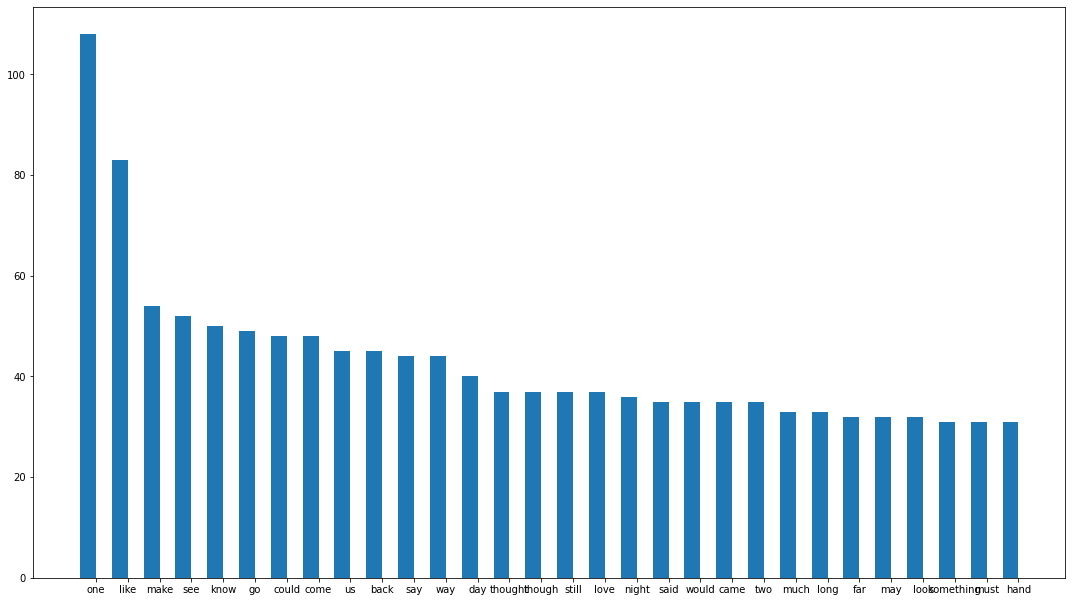

In [42]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

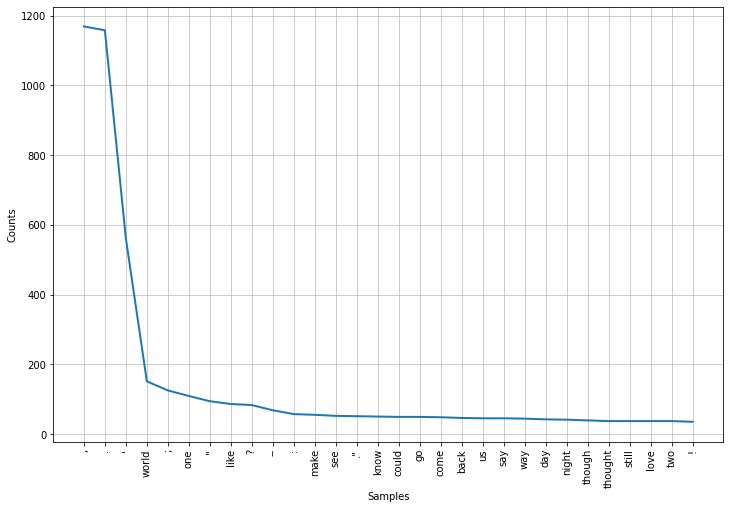

In [43]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

Cumulative distribution of frequencies:

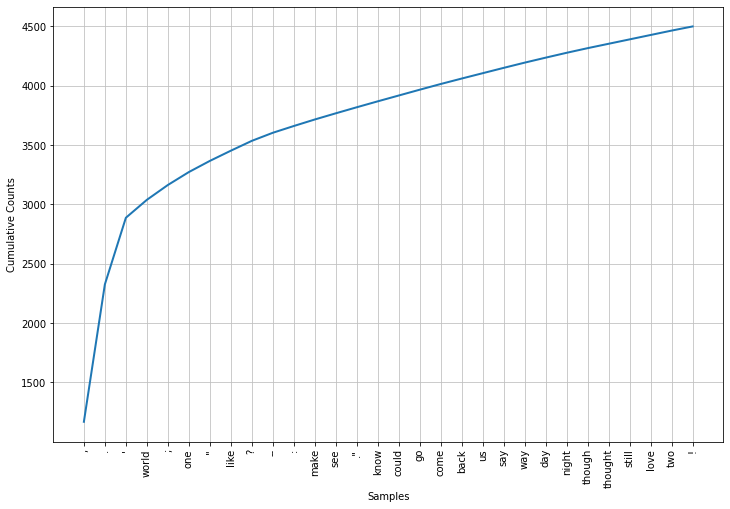

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30, cumulative = True)

## [Goose](https://github.com/goose3/goose3)

Extracting text from html pages  

In [45]:
from goose3 import Goose

url = 'https://edition.cnn.com/2021/01/26/economy/china-xi-economy-intl-hnk/index.html'

g = Goose()
#g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

In [46]:
[l for l in article.links if l.startswith('http')]

['https://www.cnn.com/2021/01/25/business/xi-jinping-wef-multilateralism-intl/index.html',
 'https://money.cnn.com/2017/01/17/news/economy/china-xi-jinping-world-economic-forum-davos/',
 'https://www.cnn.com/2021/01/25/tech/kuaishou-hong-kong-ipo-intl-hnk/index.html',
 'https://www.cnn.com/2020/08/27/business/costco-china-intl-hnk/index.html',
 'https://www.cnn.com/2021/01/19/business/tesla-china-model-y-crossover-intl-hnk/index.html',
 "https://stories.starbucks.com/press/2020/starbucks-coffee-innovation-park-in-china-extends-global-roasting-network/#:~:text=Today%2C%20Starbucks%20announced%20it%20will,Coffee%20Innovation%20Park%20(CIP).&text=The%20plant%20will%20serve%20as,the%20Company's%20global%20roasting%20network",
 'https://www.cnn.com/2020/11/19/economy/china-negative-yield-bond/index.html',
 'https://www.cnn.com/2021/01/24/asia/wuhan-one-year-on-coronavirus-intl-hnk/index.html',
 'https://www.cnn.com/2021/01/18/asia/china-covid-superspreader-intl-hnk/index.html',
 'https://ww

In [47]:
article.title

'Analysis: China is rehearsing for when it overtakes America'

In [48]:
article.meta_description

'China wants to lead the global recovery from the pandemic and become more influential on the world stage than ever before. It might just have the momentum — and the confidence — to pull that plan off.'

In [49]:
article.cleaned_text[:]

'Hong Kong (CNN Business) China wants to lead the global recovery from the pandemic and become more influential on the world stage than ever before. It might just have the momentum — and the confidence — to pull that plan off.\n\nThe world\'s second largest economy shrugged off much of the fallout from the Covid-19 pandemic last year, and its ability to keep growing while the world crashed into recession could mean its GDP exceeds that of the United States later this decade, years earlier than expected.\n\n"China emerged from the Covid-19 shock earlier than the rest of the world and authorities are already planning for the long term," wrote Françoise Huang, senior economist for Asia-Pacific at Euler Hermes, in a report last week titled, " The world is moving East, fast ."\n\nChina just outpaced the United States in attracting foreign direct investment for the first time. And as 2020 was drawing to a close, it signed a trade agreement with the European Union with the aim of boosting gro

In [50]:
print(article.top_image)

None


## [Textblob](http://textblob.readthedocs.io/en/dev/)

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/  
https://textblob-de.readthedocs.io/en/latest/api_reference.html

Installing:  
!sudo pip3 install -U textblob  
!python -m textblob.download_corpora

In [51]:
from textblob import TextBlob
from textblob import Word

In [52]:
text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant.
'''

text_de = '''
Familie Müller plant ihren Urlaub. Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. Als Reiseziel wählt sie Mallorca aus. 
Familie Müller bucht einen Flug auf die Mittelmeerinsel. Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. Familie Müller badet gerne im Meer.
Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. Dort warten schon viele Urlauber. Alle wollen nach Mallorca fliegen. 
Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 
Die Taschen sind Handgepäck. Familie Müller nimmt sie mit in das Flugzeug. 
Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. Es ist nicht mehr 
viel Zeit bis zum Abflug. Familie Müller geht durch die Sicherheitskontrolle. 
Als alle das richtige Gate erreichen, setzen sie sich in den Wartebereich. 
Kurz darauf wird ihre Flugnummer aufgerufen und Familie Müller steigt mit vielen 
anderen Passagieren in das Flugzeug nach Mallorca. Beim Starten fühlt sich Herr Müller 
nicht wohl. Ihm wird ein wenig übel. Nach zwei Stunden landet das Flugzeug. 
Am Gepäckband warten alle Passagiere noch auf ihr fehlendes Gepäck. Danach 
kann endlich der Urlaub beginnen.
'''

In [53]:
blob = TextBlob(text)
blob_de = TextBlob(text_de)

In [54]:
for s in blob.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact. 

Sentence: Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant. 



In [55]:
for s in blob_de.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
Familie Müller plant ihren Urlaub. 

Sentence: Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. 

Sentence: Als Reiseziel wählt sie Mallorca aus. 

Sentence: Familie Müller bucht einen Flug auf die Mittelmeerinsel. 

Sentence: Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. 

Sentence: Familie Müller badet gerne im Meer. 

Sentence: Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. 

Sentence: Dort warten schon viele Urlauber. 

Sentence: Alle wollen nach Mallorca fliegen. 

Sentence: Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 

Sentence: Die Taschen sind Handgepäck. 

Sentence: Familie Müller nimmt sie mit in das Flugzeug. 

Sentence: Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. 

Sentence: Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. 

Sentence: Es ist nicht mehr 
viel Zeit bis zum Abflug. 

Sentence: 

In [56]:
blob.sentences[1].words

WordList(['Snide', 'comparisons', 'to', 'gelatin', 'be', 'damned', 'it', "'s", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequences', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorists', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

Functions applied to the Word object:  

In [57]:
blob.sentences[1].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [58]:
w = Word('Platform')
w.pluralize()

'Platforms'

Lemmatization  

In [59]:
w = Word('running')
w.lemmatize("v") ## v here represents verb

'run'

POS tags  

In [60]:
blob.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [61]:
blob_de.tags[0:10]

[('Familie', 'NNP'),
 ('Müller', 'NNP'),
 ('plant', 'NN'),
 ('ihren', 'NN'),
 ('Urlaub', 'NNP'),
 ('Sie', 'NNP'),
 ('geht', 'NN'),
 ('in', 'IN'),
 ('ein', 'JJ'),
 ('Reisebüro', 'NNP')]

Ngrams  

In [62]:
for ngram in blob.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'chillingly']
['chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [63]:
blob.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists', 'artificial intelligence run rampant'])

In [64]:
blob_de.noun_phrases

WordList(['familie müller', 'plant ihren', 'urlaub', 'sie', 'reisebüro', 'und lässt sich von einem', 'angestellten', 'als reiseziel', 'wählt sie', 'mallorca', 'familie müller', 'bucht einen', 'flug', 'mittelmeerinsel', 'sie', 'bucht außerdem zwei', 'zimmer', 'einem großen hotel direkt', 'strand', 'familie müller', 'badet gerne im', 'meer', 'am abflugtag', 'herr', 'frau müller', 'mit ihren beiden', 'kindern', 'taxi', 'flughafen', 'dort', 'warten schon viele', 'urlauber', 'alle', 'wollen nach', 'mallorca', 'familie müller', 'hat viel', 'gepäck', 'drei große', 'koffer', 'und zwei', 'taschen', 'die taschen', 'handgepäck', 'familie müller', 'nimmt sie mit', 'flugzeug', 'am flugschalter', 'familie', 'ein und erhält ihre', 'bordkarten', 'die angestellte', 'flugschalter', 'herrn müller', 'weg', 'flugsteig', 'es', 'ist nicht mehr viel', 'zeit', 'bis zum', 'abflug', 'familie müller', 'geht durch', 'sicherheitskontrolle', 'als', 'alle das richtige gate erreichen', 'setzen sie sich', 'wartebereich

Sentiment Analysis  

In [65]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


Translation

In [66]:
blob.translate(to="de")

TextBlob("Die Titelbedrohung von The Blob hat mich immer als den ultimativen Film empfunden
Monster: eine unersättlich hungrige, amöbenähnliche Masse, die eindringen kann
praktisch jeder Schutz, der in der Lage ist - als zum Scheitern verurteilter Arzt kühl
beschreibt es - "Fleisch bei Kontakt aufnehmen.
Snide Vergleiche mit Gelatine sind verdammt, es ist ein Konzept mit den meisten
verheerende mögliche Konsequenzen, ähnlich wie im Szenario der grauen Gänsehaut
vorgeschlagen von Technologietheoretikern usw., aus Angst vor
künstliche Intelligenz ist weit verbreitet.")

Detecting language

In [67]:
blob_de.detect_language()

'de'

Spellcheck

In [68]:
sentence = TextBlob('The Austrien Centre for Digital Humanities and Cultural Heritaige from the Austrian Academy of Sciences')
sentence.correct()

TextBlob("The Austrian Centre for Digital Humanities and Cultural Heritage from the Austrian Academy of Sciences")

In [69]:
blob.words[5].spellcheck()

[('Low', 0.19878603945371776),
 ('Blow', 0.10925644916540213),
 ('Club', 0.10773899848254932),
 ('Clot', 0.1062215477996965),
 ('Slow', 0.09863429438543247),
 ('Flow', 0.07283763277693475),
 ('Lot', 0.05311077389984825),
 ('Mob', 0.03945371775417299),
 ('Glow', 0.03338391502276176),
 ('Log', 0.030349013657056147),
 ('Sob', 0.028831562974203338),
 ('Globe', 0.024279210925644917),
 ('Plot', 0.018209408194233688),
 ('Job', 0.01669195751138088),
 ('Plow', 0.013657056145675266),
 ('Rob', 0.007587253414264037),
 ('Slab', 0.006069802731411229),
 ('Los', 0.004552352048558422),
 ('Bob', 0.004552352048558422),
 ('Knob', 0.0030349013657056147),
 ('Flop', 0.0030349013657056147),
 ('Flog', 0.0030349013657056147),
 ('Blot', 0.0030349013657056147),
 ('Slot', 0.0015174506828528073),
 ('Slop', 0.0015174506828528073),
 ('Loi', 0.0015174506828528073),
 ('Lo', 0.0015174506828528073),
 ('Lb', 0.0015174506828528073),
 ('Lab', 0.0015174506828528073),
 ('Cob', 0.0015174506828528073),
 ('Bloc', 0.0015174506828

Text classification

In [70]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
("Let's pretend \"Batman and Robin\" never happened..",'neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

In [71]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [72]:
print (nb_classifier.accuracy(testing))

1.0


In [73]:
print (dt_classifier.accuracy(testing))

0.6666666666666666


In [74]:
nb_classifier.show_informative_features(4)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
             contains(a) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0


In [75]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


## [Spacy](https://spacy.io/)

https://spacy.io/usage/spacy-101#lightning-tour  
https://github.com/explosion/spacy-notebooks  
https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb  

In [80]:
!pip install -U spacy

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!python -m spacy download pt_core_news_sm
!python -m spacy download de_core_news_md

!python -m spacy validate

Defaulting to user installation because normal site-packages is not writeable
2021-05-21 00:04:40.954423: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-21 00:04:40.954453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.7 MB 17.4 MB/s eta 0:00:01█████████             | 8.1 MB 4.2 MB/s eta 0:00:02
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-05-21 00:04:48.004260: W tensorflow/stream_ex

Load resources and process text

In [81]:
import spacy

In [83]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
pt_nlp = spacy.load('pt_core_news_sm')

In [94]:
text_german = '''
Der du von dem Himmel bist,
Alles Leid und Schmerzen stillest,
Den, der doppelt elend ist,
Doppelt mit Erquickung füllest;
Ach, ich bin des Treibens müde!
Was soll all der Schmerz und Lust?
Süßer Friede,
Komm, ach komm in meine Brust!
'''

text_english = '''
somewhere i have never travelled,gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near.
Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully,mysteriously)her first rose.
Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility:whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing.
I do not know what it is about you that closes
and opens;only something in me understands
the voice of your eyes is deeper than all roses)
nobody,not even the rain,has such small hands.

'''

text_portuguese = '''
Ora (direis) ouvir estrelas! Certo
Perdeste o senso!" E eu vos direi, no entanto,
Que, para ouvi-las, muita vez desperto
E abro as janelas, pálido de espanto...

E conversamos toda a noite, enquanto
A via-láctea, como um pálio aberto,
Cintila. E, ao vir do sol, saudoso e em pranto,
Inda as procuro pelo céu deserto.

Direis agora: "Tresloucado amigo!
Que conversas com elas? Que sentido
Tem o que dizem, quando estão contigo?"

E eu vos direi: "Amai para entendê-las!
Pois só quem ama pode ter ouvido
Capaz de ouvir e de entender estrelas. 
'''

In [95]:
en_doc = en_nlp(text_english)
de_doc = de_nlp(text_german)
pt_doc = pt_nlp(text_portuguese)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [96]:
print(en_doc[0:7])


somewhere i have never travelled,


You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [97]:
en_Sents = list(en_doc.sents)
print(en_Sents)

[
somewhere, i have never travelled,gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near., 
, Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully,mysteriously)her first rose., 
, Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility:whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing., 
, I do not know what it is about you that closes
and opens;only something in me understands
the voice of your eyes is deeper than all roses), 
nobody,not even the rain,has such small hands., 

]


For example, let's find the longest sentence(s):

In [98]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

[Or if your wish be to close me,i and
 my life will shut very beautifully,suddenly,
 as when the heart of this flower imagines
 the snow carefully everywhere descending;
 nothing which we are to perceive in this world equals
 the power of your intense fragility:whose texture
 compels me with the colour of its countries,
 rendering death and forever with each breathing.]

Exploring Words  
Each word has a crazy number of properties:

In [124]:
print(en_doc[2])
print(type(en_doc[2]))

titular
<class 'spacy.tokens.token.Token'>


In [99]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'set_morph',
 'shape',
 'sh

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [100]:
en_doc[2].i

2

In [101]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram([word.i for word in haystack if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc399bfa610>,
      dtype=object)

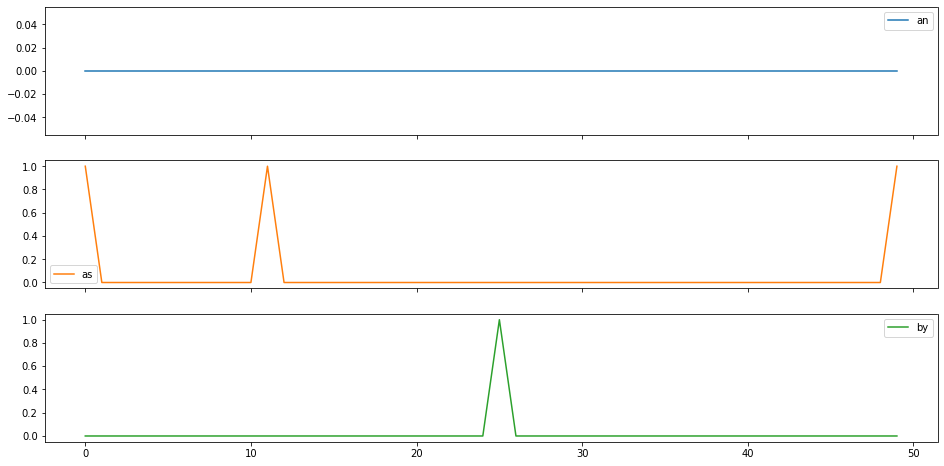

In [102]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring [Named Entities](https://spacy.io/api/annotation)

Named entities can be accessed through doc.ents

In [103]:
set([w.label_ for w in en_doc.ents])

{'ORDINAL'}

In [104]:
[ent for ent in en_doc.ents if ent.label_ == 'PERSON']

[]

In [105]:
[ent for ent in en_doc.ents if ent.label_ == 'GPE']

[]

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [107]:
tagDict = {w.pos: w.pos_ for w in en_doc} 
tagDict

{103: 'SPACE',
 86: 'ADV',
 95: 'PRON',
 87: 'AUX',
 100: 'VERB',
 97: 'PUNCT',
 85: 'ADP',
 90: 'DET',
 92: 'NOUN',
 84: 'ADJ',
 89: 'CCONJ',
 94: 'PART',
 98: 'SCONJ',
 96: 'PROPN'}

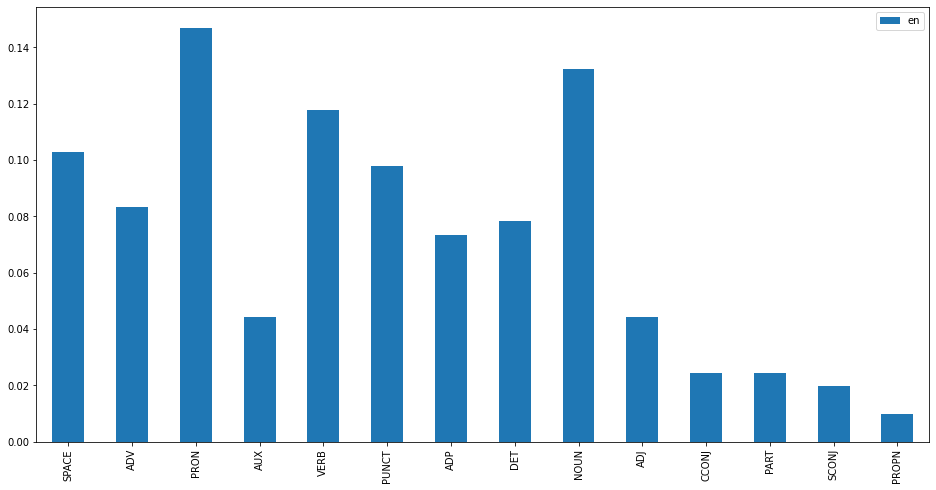

In [108]:
en_docPOS = pd.Series(en_doc.count_by(spacy.attrs.POS))/len(en_doc)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [116]:
en_docProns = [w for w in en_doc if w.pos_ == 'PRON']
Counter([w.text.strip() for w in en_docProns]).most_common(10)

[('your', 5),
 ('me', 5),
 ('i', 4),
 ('myself', 2),
 ('you', 2),
 ('their', 1),
 ('they', 1),
 ('Your', 1),
 ('my', 1),
 ('nothing', 1)]

In [118]:
en_docSents = [sent for sent in en_doc.sents if 'of' in sent.text]
en_docSents

[Or if your wish be to close me,i and
 my life will shut very beautifully,suddenly,
 as when the heart of this flower imagines
 the snow carefully everywhere descending;
 nothing which we are to perceive in this world equals
 the power of your intense fragility:whose texture
 compels me with the colour of its countries,
 rendering death and forever with each breathing.,
 I do not know what it is about you that closes
 and opens;only something in me understands
 the voice of your eyes is deeper than all roses)]

In [119]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)

I PRP PRON
do VBP AUX
not RB PART
know VB VERB
what WP PRON
it PRP PRON
is VBZ AUX
about IN ADP
you PRP PRON
that WDT DET
closes VBZ VERB

 _SP SPACE
and CC CCONJ
opens;only RB ADV
something NN PRON
in IN ADP
me PRP PRON
understands VBZ VERB

 _SP SPACE
the DT DET
voice NN NOUN
of IN ADP
your PRP$ PRON
eyes NNS NOUN
is VBZ AUX
deeper JJR ADJ
than IN SCONJ
all DT DET
roses NNS NOUN
) -RRB- PUNCT


Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [120]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [121]:
en_docSents[1].root

know

In [122]:
list(en_docSents[1].root.children)

[I, do, not, is, closes, and, understands]

In [123]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))

I :  []
do :  []
not :  []
know :  [I, do, not, is, closes, and, understands]
what :  []
it :  []
is :  [what, it, about]
about :  [you]
you :  []
that :  []
closes :  [that, 
]

 :  []
and :  []
opens;only :  []
something :  [in]
in :  [me]
me :  []
understands :  [opens;only, something, 
, is]

 :  []
the :  []
voice :  [the, of]
of :  [eyes]
your :  []
eyes :  [your]
is :  [voice, deeper, )]
deeper :  [than]
than :  [roses]
all :  []
roses :  [all]
) :  []


In [125]:
for sent in en_docSents: 
    for word in sent: 
        if 'as' in word.text: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

In [126]:
Counter([w.string.strip() for w in en_doc.ents if w.label_ == 'PERSON']).most_common(10)

[]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find:

In [129]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.text]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

In [130]:
adjectivesDescribingCharacters(en_doc, 'Blob')

[]

or verbs:

In [133]:
def verbsForCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.text]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [134]:
verbsForCharacters(en_doc, 'Blob')

[]

Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

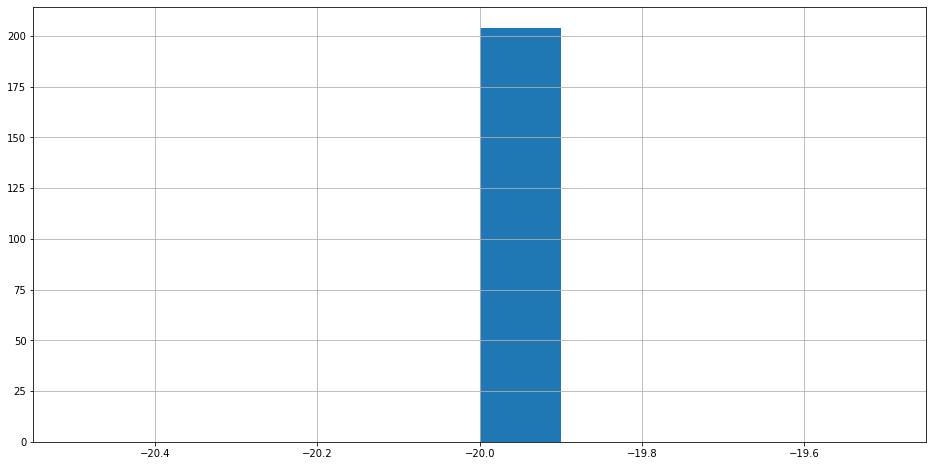

In [135]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [137]:
list(set([word.text.strip().lower() for word in en_doc if word.prob < -19]))[:20]

['',
 'slightest',
 'about',
 'if',
 'look',
 'whose',
 'enclose',
 'descending',
 'hands',
 'easily',
 'shut',
 'can',
 'too',
 'death',
 'mysteriously)her',
 'i',
 'your',
 'rose',
 'carefully',
 'than']

In [138]:
Counter([word.text.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

[('', 21),
 (',', 11),
 ('your', 6),
 ('the', 6),
 ('i', 5),
 ('me', 5),
 ('.', 4),
 ('of', 4),
 ('have', 3),
 ('in', 3),
 ('are', 3),
 ('which', 3),
 ('not', 3),
 ('as', 3),
 ('and', 3),
 ('eyes', 2),
 (':', 2),
 ('or', 2),
 ('will', 2),
 ('myself', 2)]

In [141]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.text.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [142]:
docGrams = set(ngrams(en_doc, 3))

In [143]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(frail, gesture, are)
(your, most, frail)
(they, are, too)
(suddenly, as, when)
(your, intense, fragility)
(the, heart, of)
(everywhere, descending, nothing)
(we, are, to)
(their, silence, in)
(which, i, can)
(touch, because, they)
(any, experience, your)
(than, all, roses)
(understands, the, voice)
(are, things, which)
(each, breathing, do)
(always, petal, by)
(all, roses, nobody)
(power, of, your)
(as, when, the)
(the, voice, of)
(i, can, not)
(whose, texture, compels)
(enclose, me, or)
(silence, in, your)
(compels, me, with)
(are, too, near)
(me, though, i)
(rain, has, such)
(what, it, is)
(the, power, of)
(me, i, and)
(you, that, closes)
(be, to, close)
(in, your, most)
(me, understands, the)
(rose, Or, if)
(eyes, have, their)
(your, eyes, is)
(death, and, forever)
(imagines, the, snow)
(open, always, petal)
(this, flower, imagines)
(petal, myself, as)
(even, the, rain)
(i, and, my)
(Your, slightest, look)
(my, life, will)
(roses, nobody, not)
(somewhere, i, have)
(near, Your, slig

## Example 3 - Full EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [144]:
news= pd.read_csv(os.path.join(datapath, 'Texts','abcnews-date-text.csv'),nrows=10000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

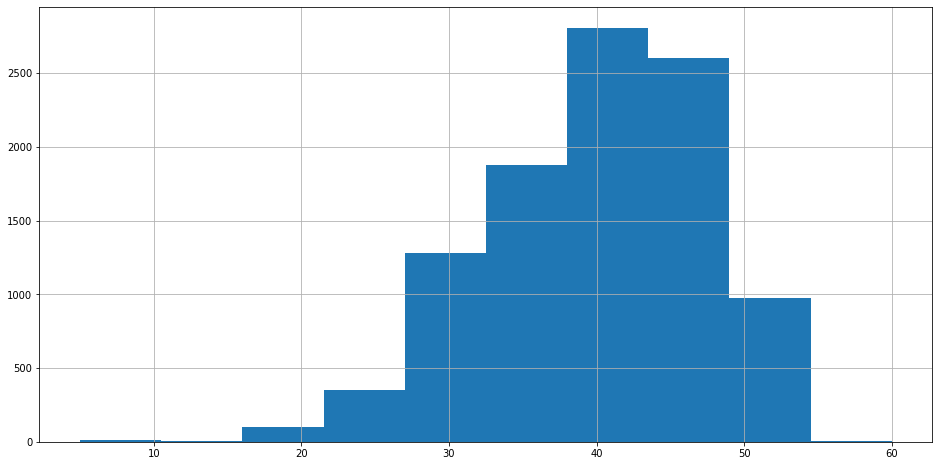

In [145]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

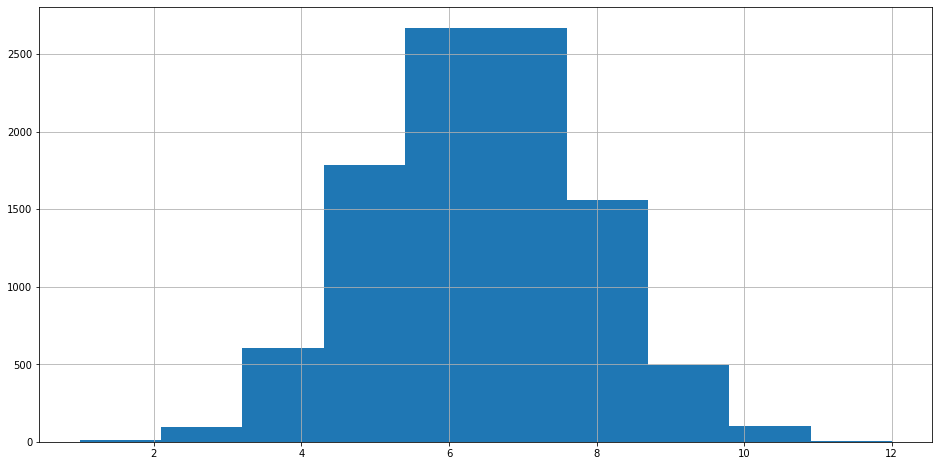

In [146]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

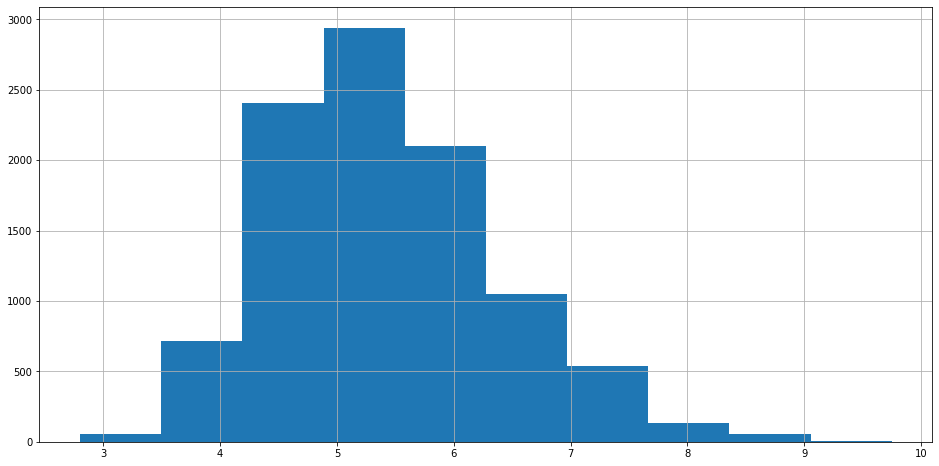

In [147]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [148]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [149]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

<BarContainer object of 10 artists>

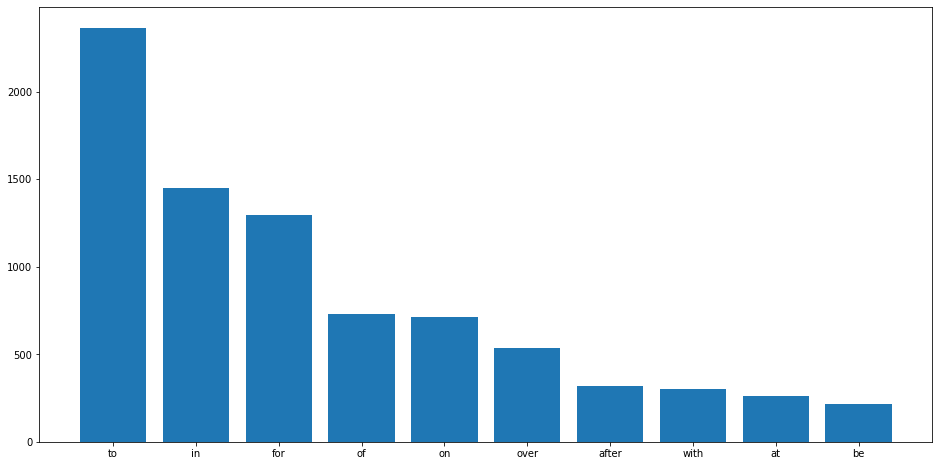

In [150]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

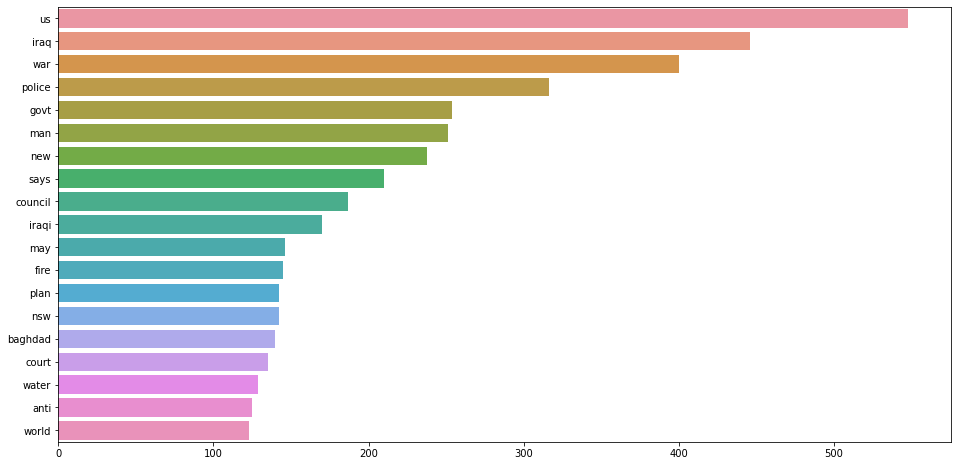

In [151]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [152]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

#### To build a representation of our vocabulary we will use Countvectorizer.

In [153]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

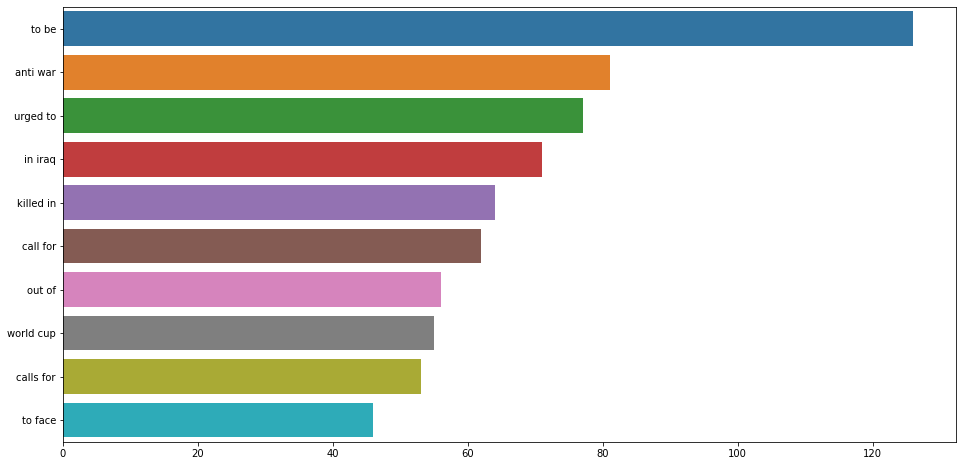

In [154]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

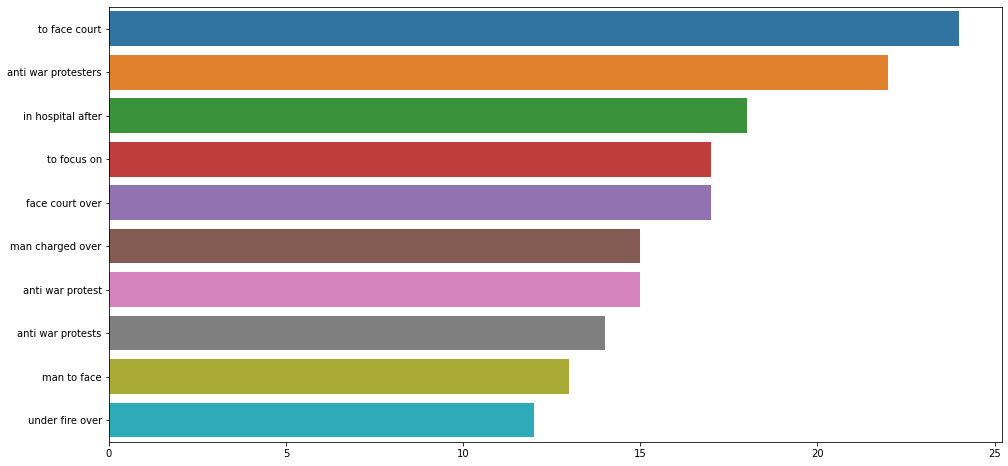

In [155]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [156]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

[nltk_data] Downloading package punkt to /home/rsouza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rsouza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now, let’s create the bag of words model using gensim

In [157]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [158]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.019*"war" + 0.017*"iraq" + 0.008*"say" + 0.007*"new" + 0.007*"plan" + 0.006*"council" + 0.005*"govt" + 0.005*"win" + 0.005*"back" + 0.004*"hope"'),
 (1,
  '0.007*"win" + 0.006*"world" + 0.006*"fire" + 0.006*"may" + 0.005*"cup" + 0.004*"rain" + 0.004*"community" + 0.004*"claim" + 0.004*"farmer" + 0.004*"urged"'),
 (2,
  '0.014*"iraq" + 0.008*"iraqi" + 0.007*"govt" + 0.007*"war" + 0.006*"say" + 0.006*"call" + 0.006*"new" + 0.006*"report" + 0.005*"troop" + 0.004*"anti"'),
 (3,
  '0.019*"police" + 0.016*"man" + 0.010*"baghdad" + 0.008*"court" + 0.007*"face" + 0.006*"crash" + 0.005*"charge" + 0.005*"iraqi" + 0.005*"charged" + 0.005*"coalition"')]

#### What is the Dominant topic and its percentage contribution in each document

In [159]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8748,"win, world, fire, may, cup, rain, community, c...",aba decides against community broadcasting lic...
1,1,1.0,0.8887,"win, world, fire, may, cup, rain, community, c...",act fire witnesses must be aware of defamation
2,2,2.0,0.8452,"iraq, iraqi, govt, war, say, call, new, report...",a g calls for infrastructure protection summit
3,3,2.0,0.8906,"iraq, iraqi, govt, war, say, call, new, report...",air nz staff in aust strike for pay rise
4,4,2.0,0.8617,"iraq, iraqi, govt, war, say, call, new, report...",air nz strike to affect australian travellers
5,5,0.0,0.6361,"war, iraq, say, new, plan, council, govt, win,...",ambitious olsson wins triple jump
6,6,2.0,0.8745,"iraq, iraqi, govt, war, say, call, new, report...",antic delighted with record breaking barca
7,7,1.0,0.5463,"win, world, fire, may, cup, rain, community, c...",aussie qualifier stosur wastes four memphis match
8,8,2.0,0.8681,"iraq, iraqi, govt, war, say, call, new, report...",aust addresses un security council over iraq
9,9,0.0,0.8729,"war, iraq, say, new, plan, council, govt, win,...",australia is locked into war timetable opp


#### Frequency Distribution of Word Counts in Documents

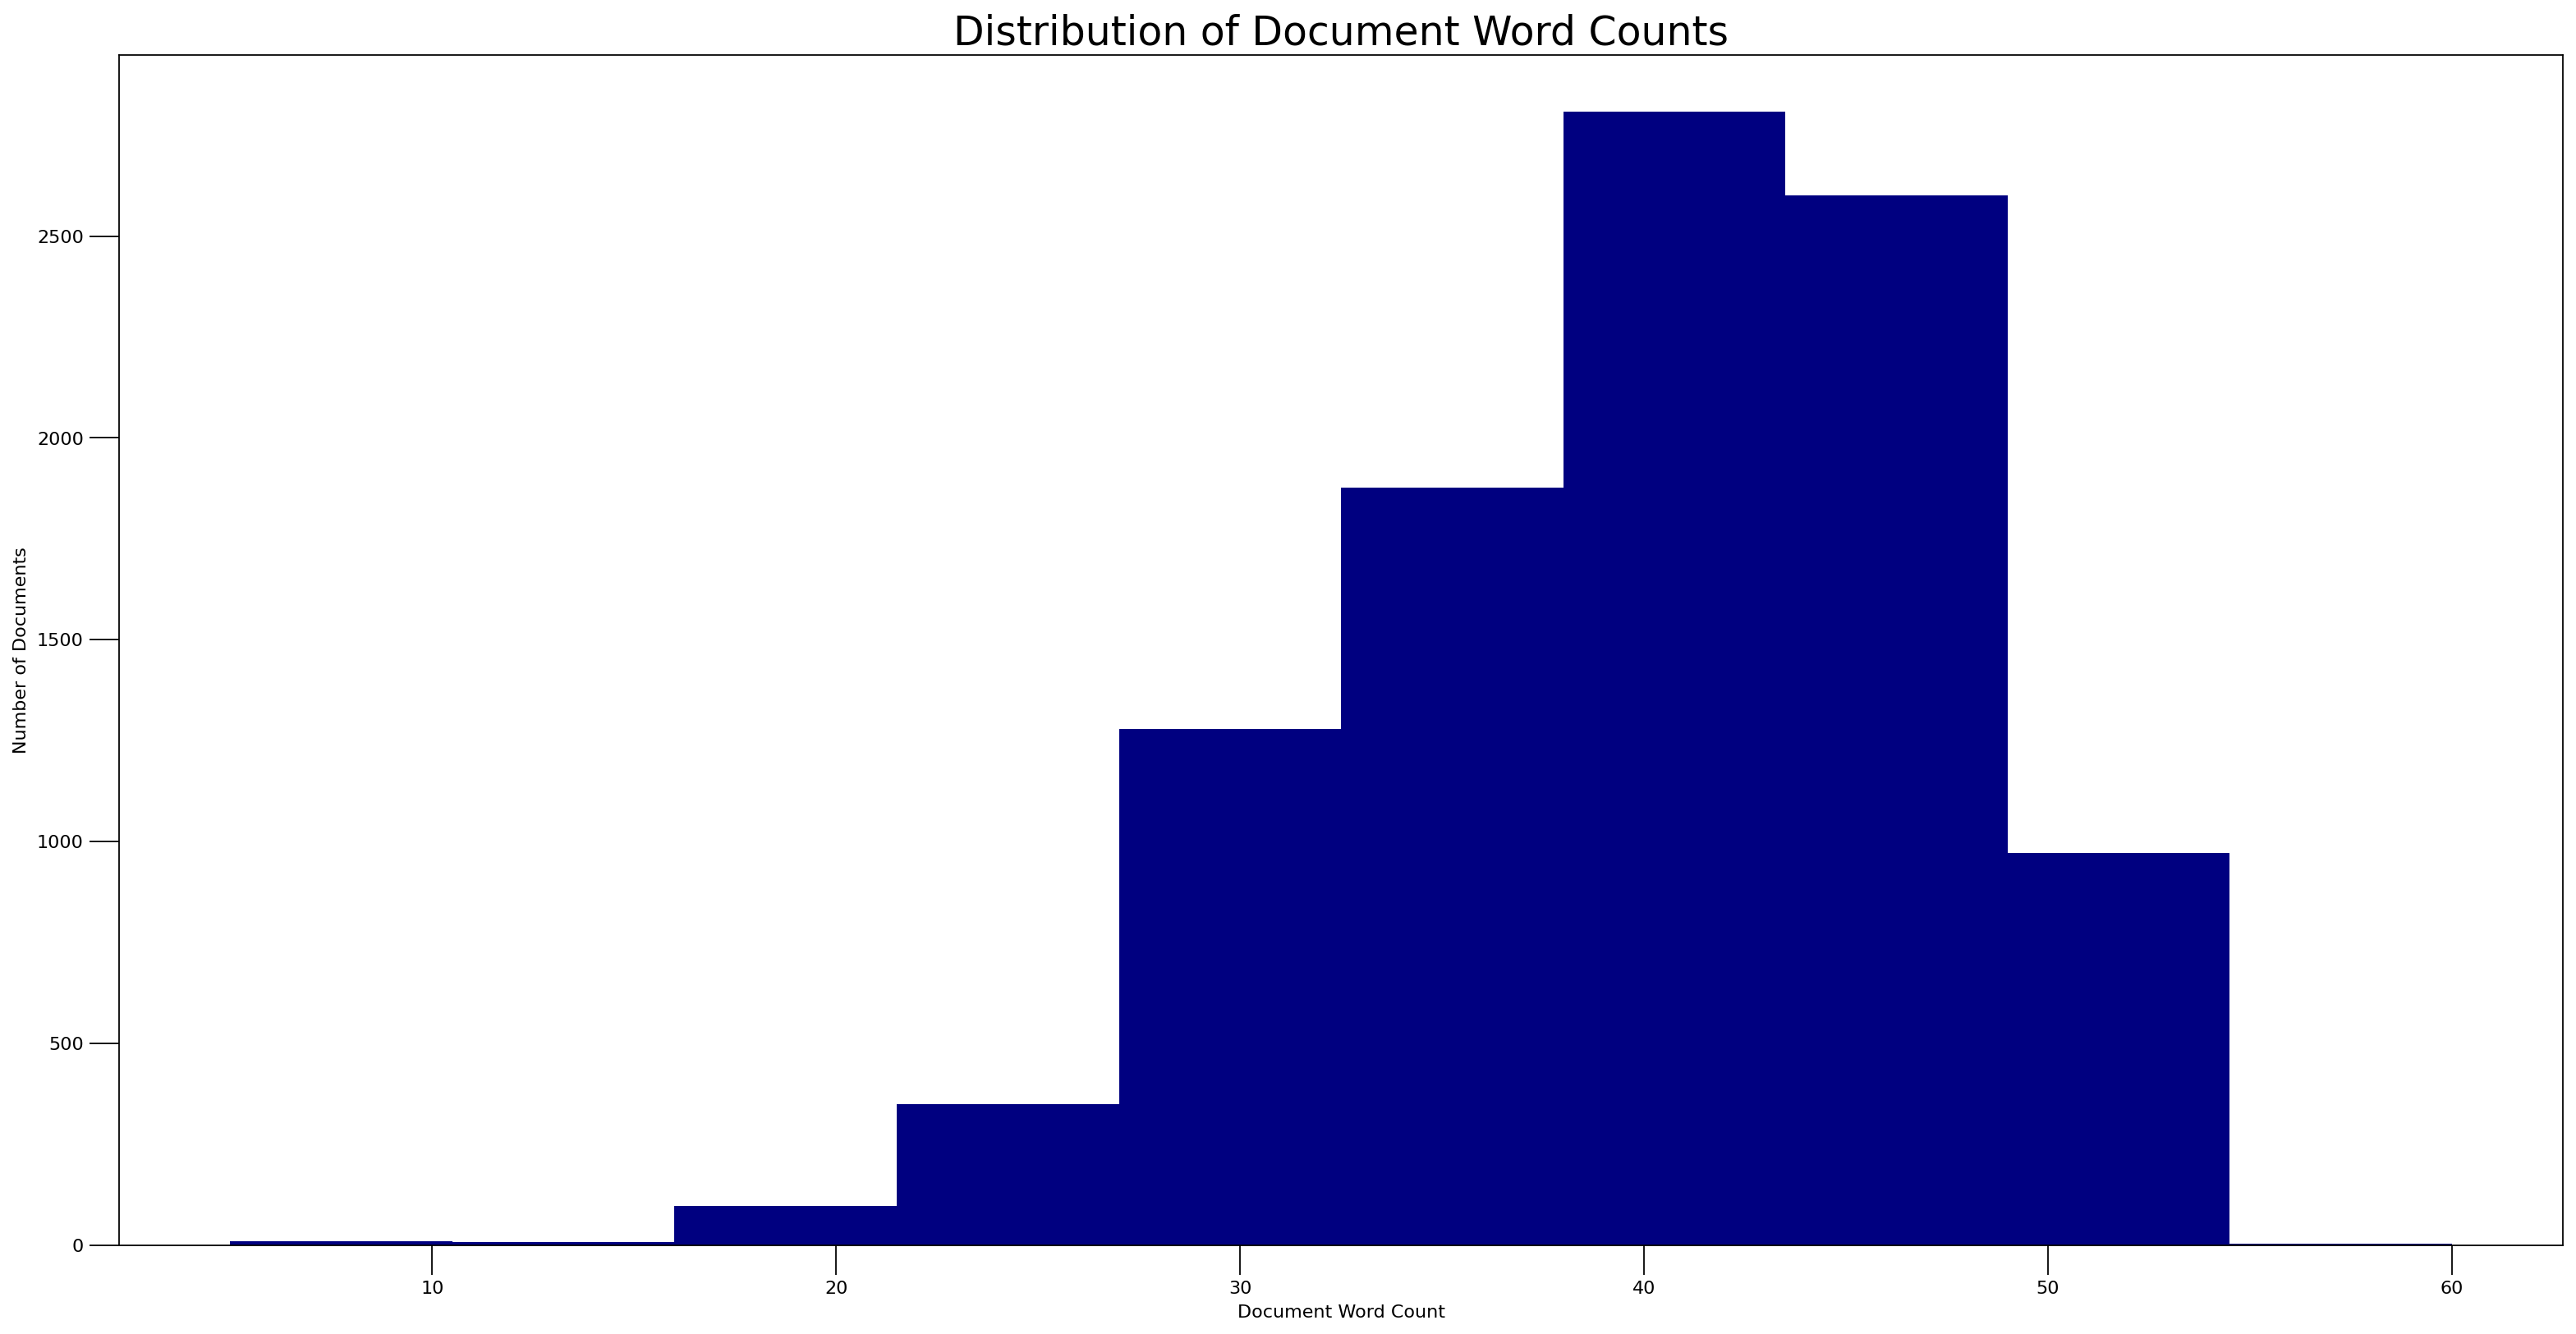

In [160]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

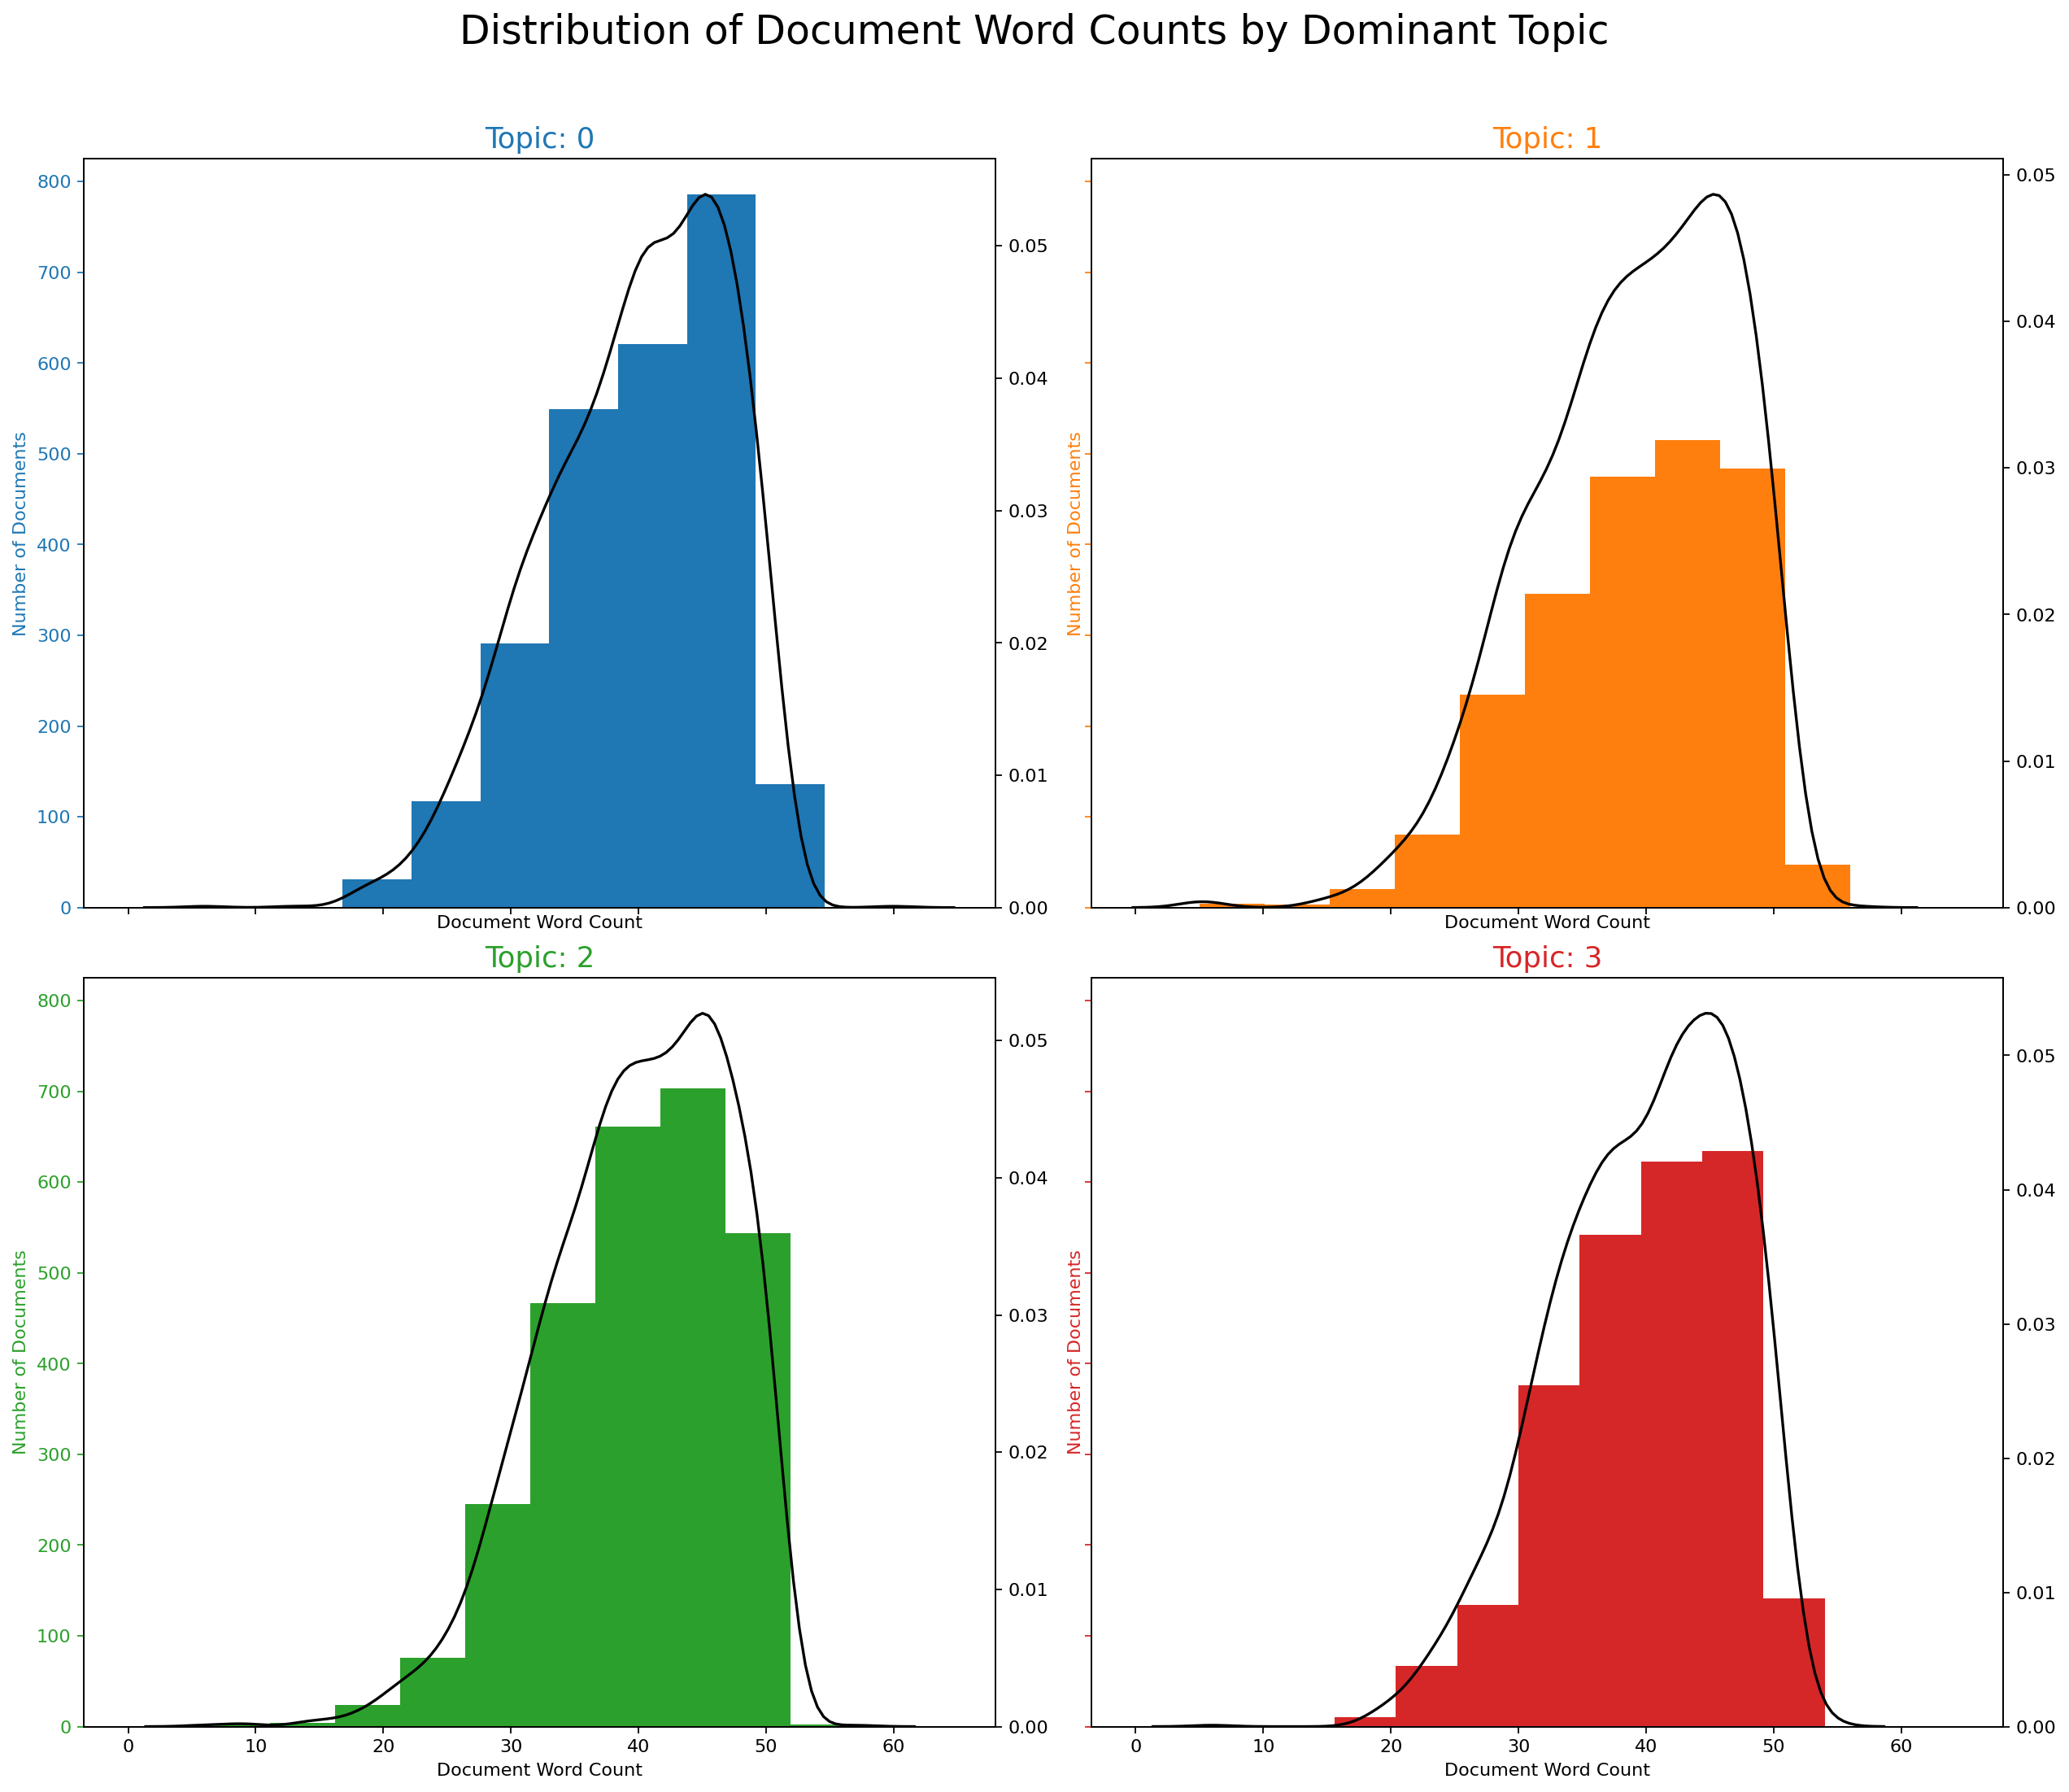

In [161]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

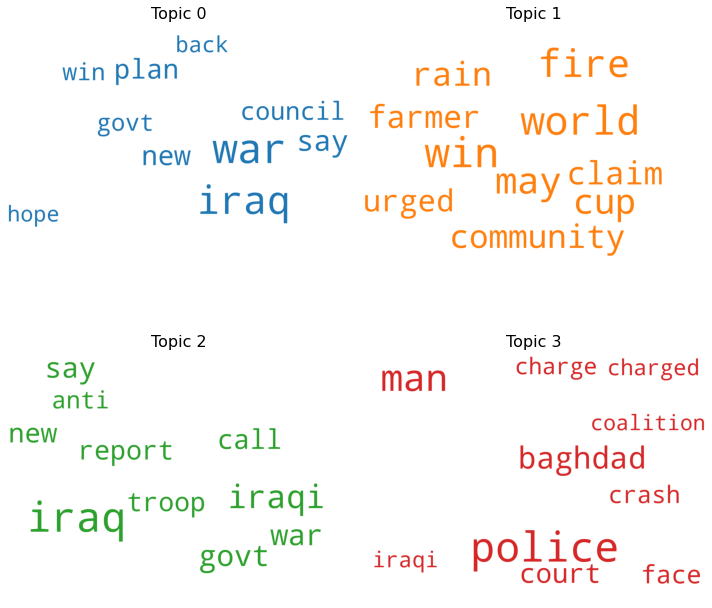

In [162]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

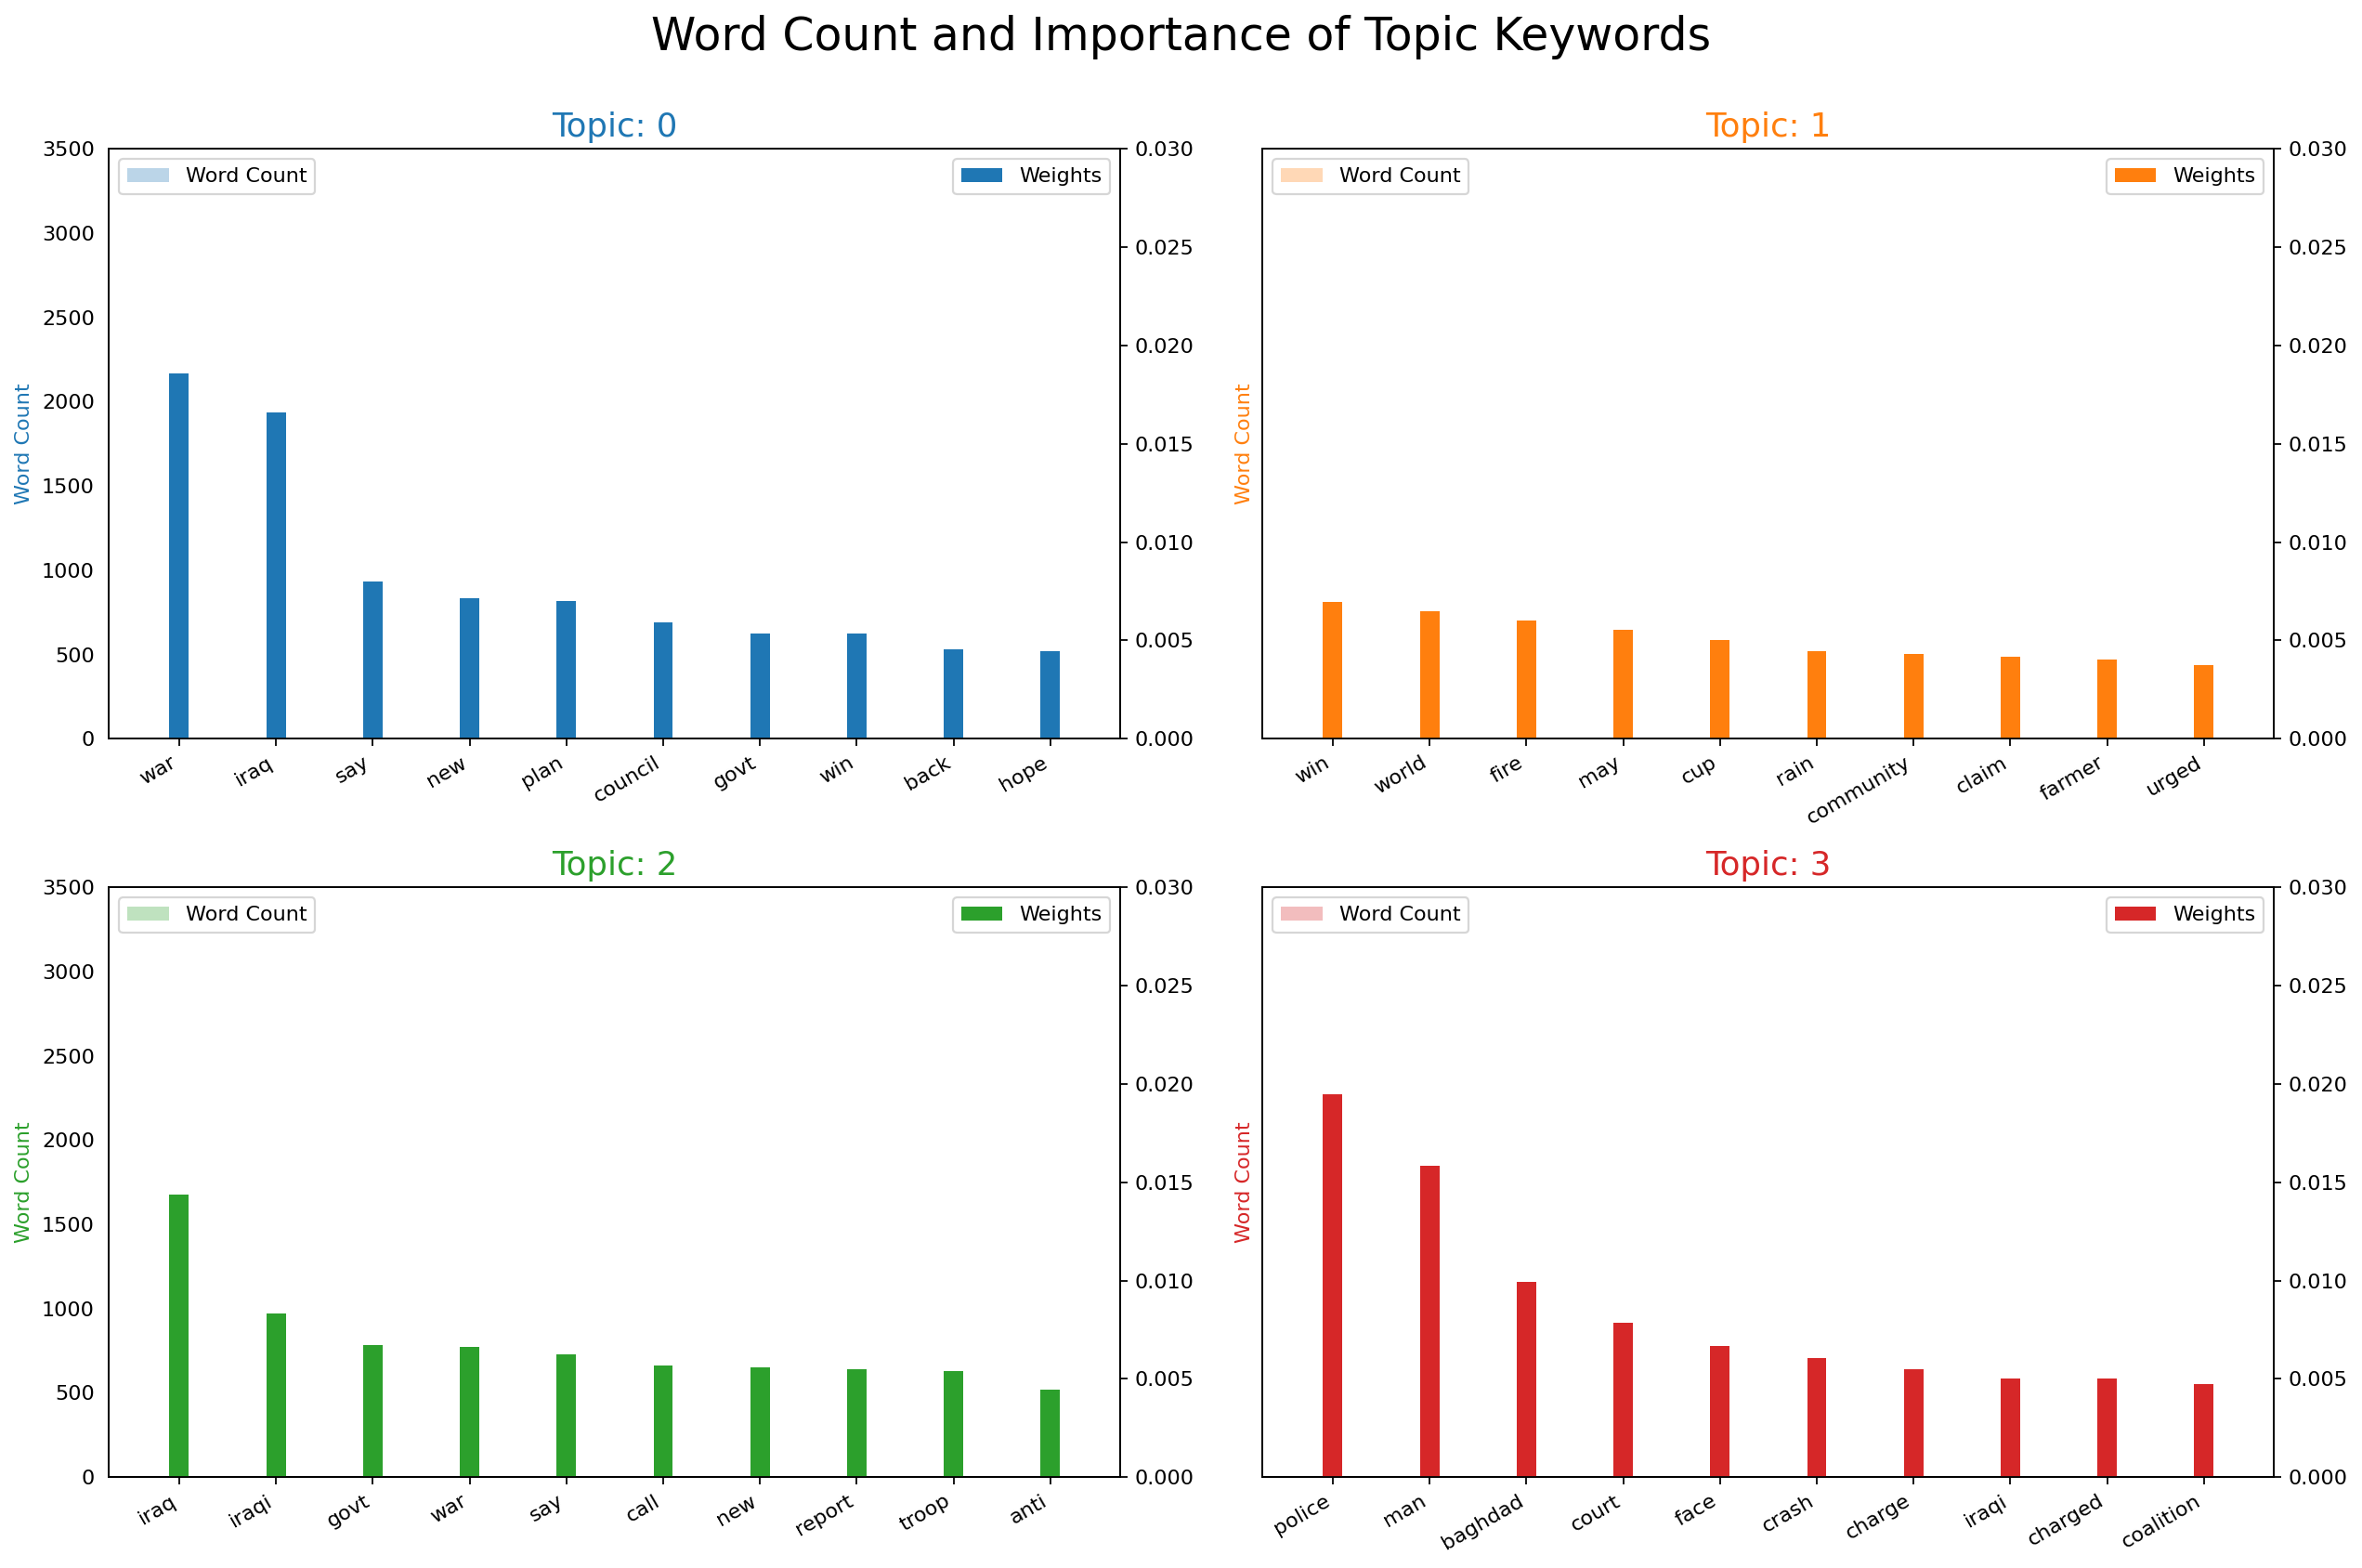

In [163]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

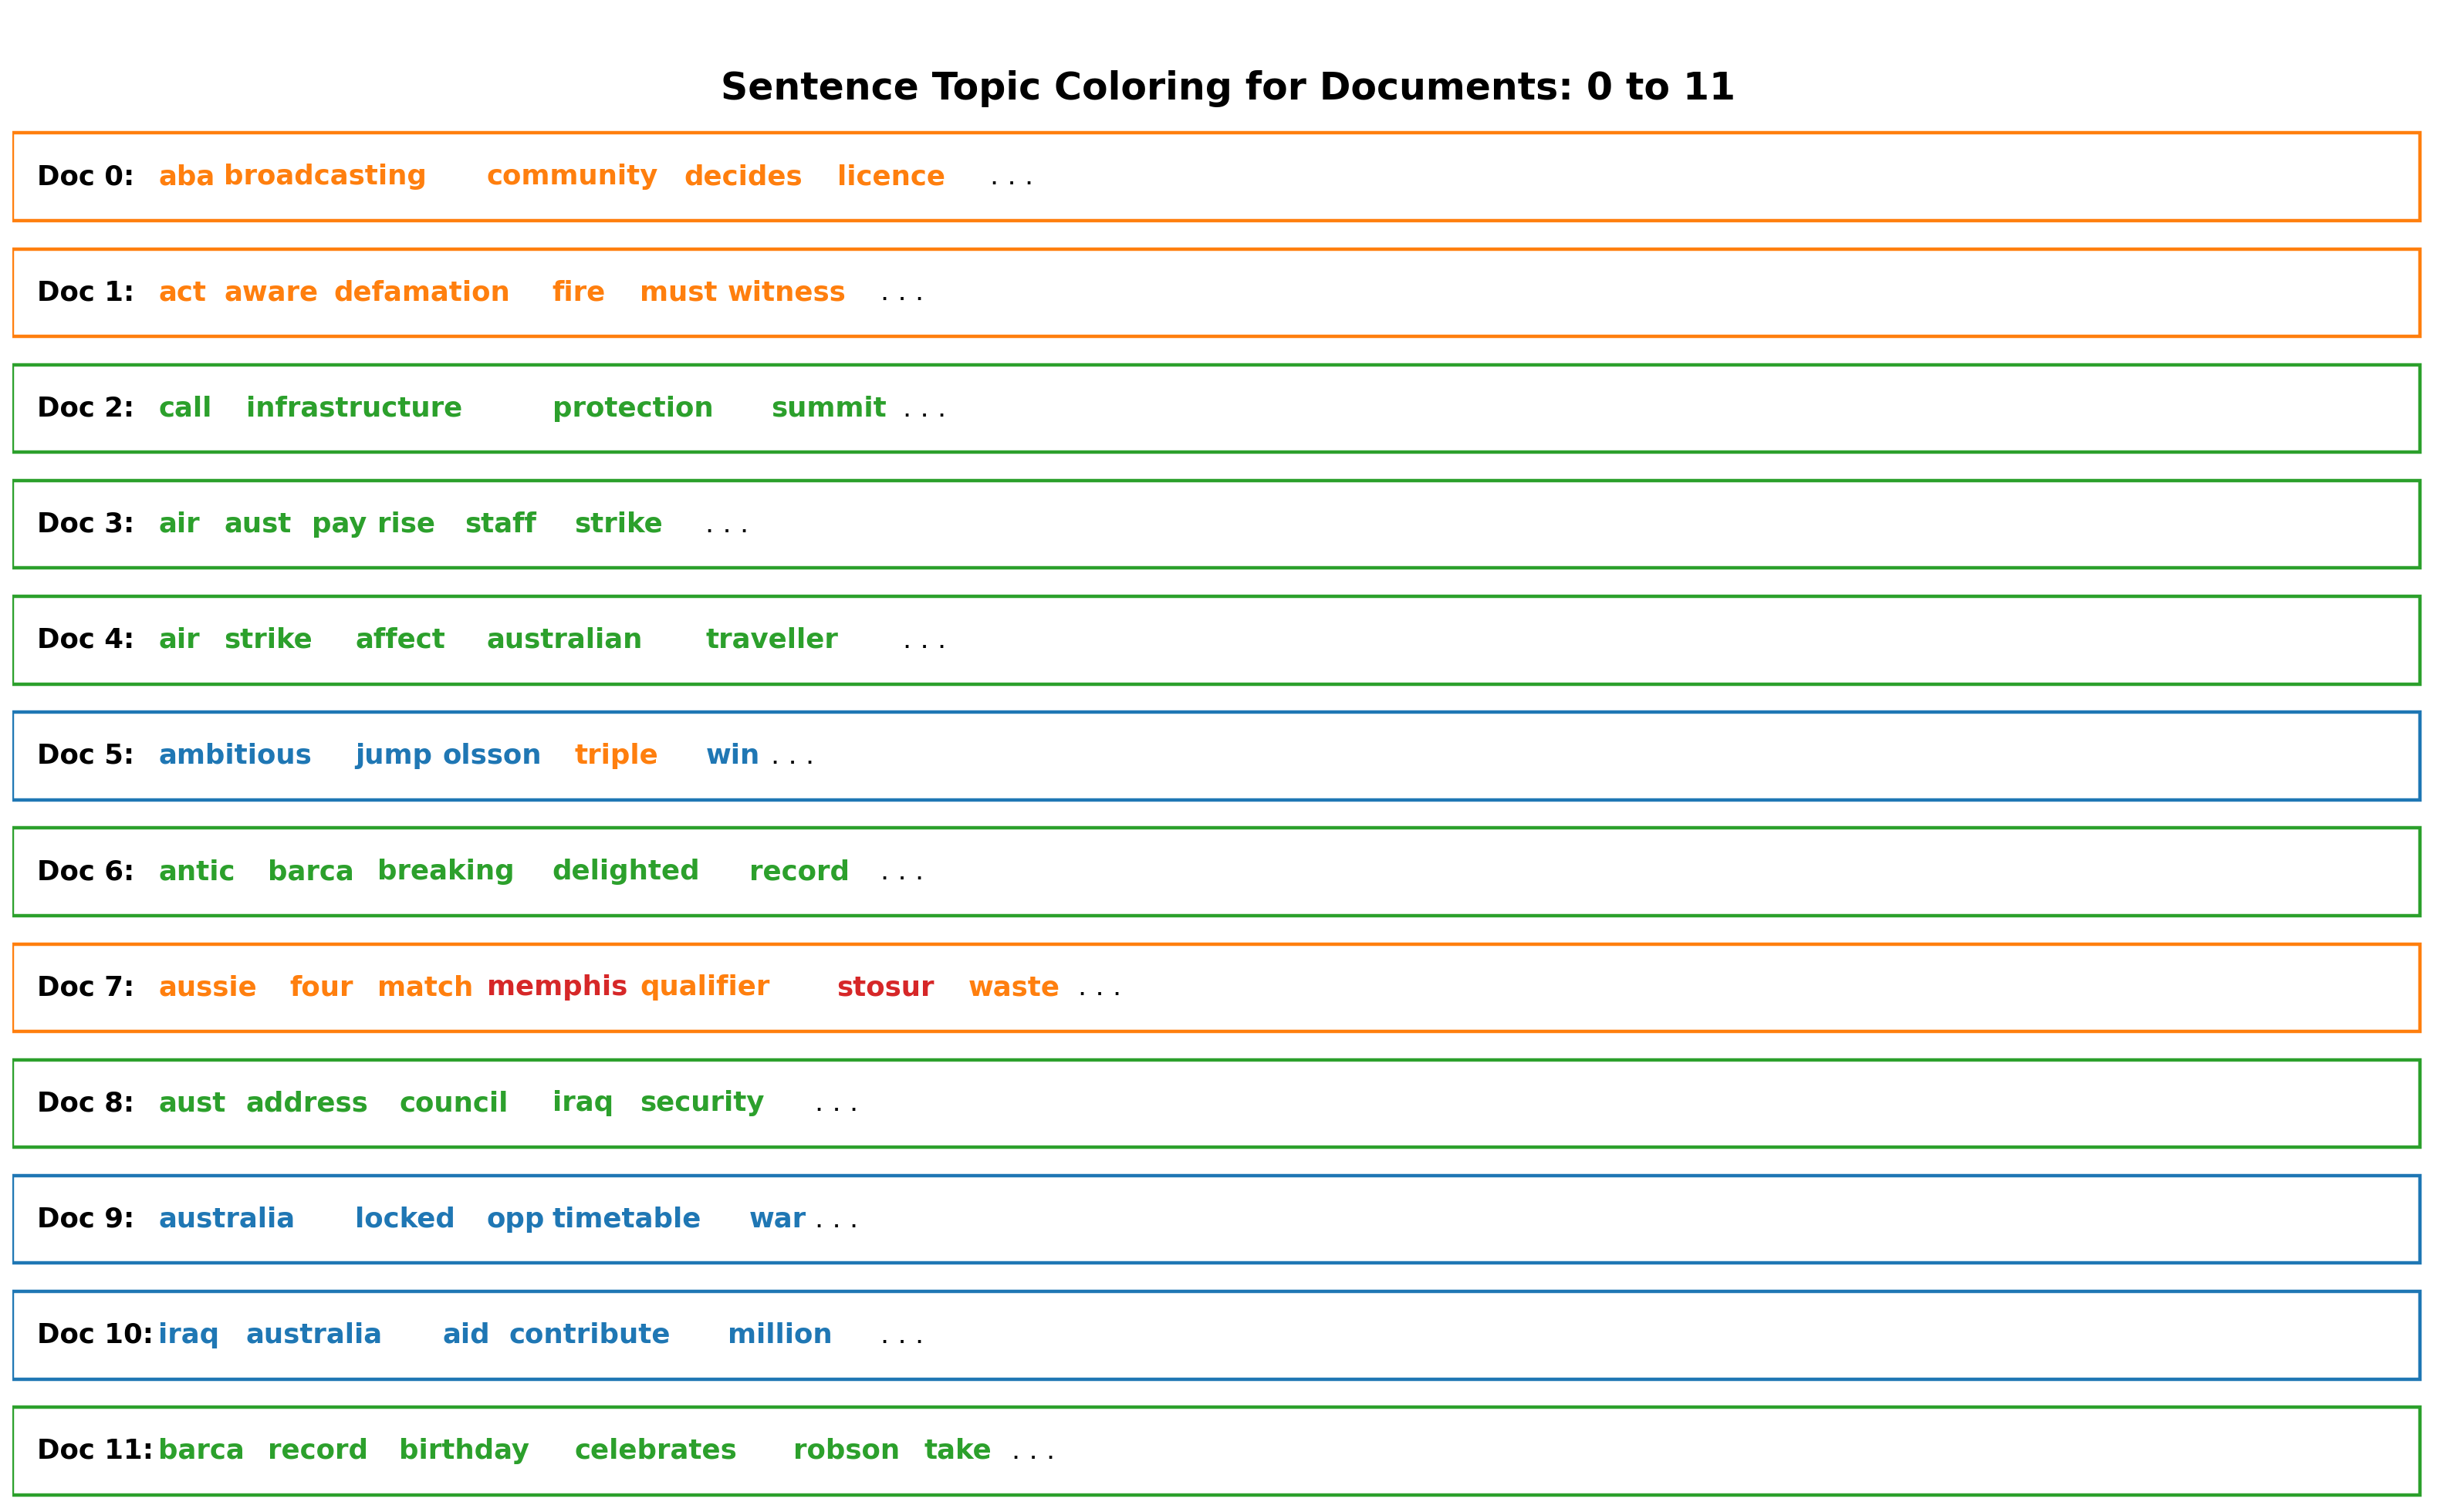

In [164]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [165]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

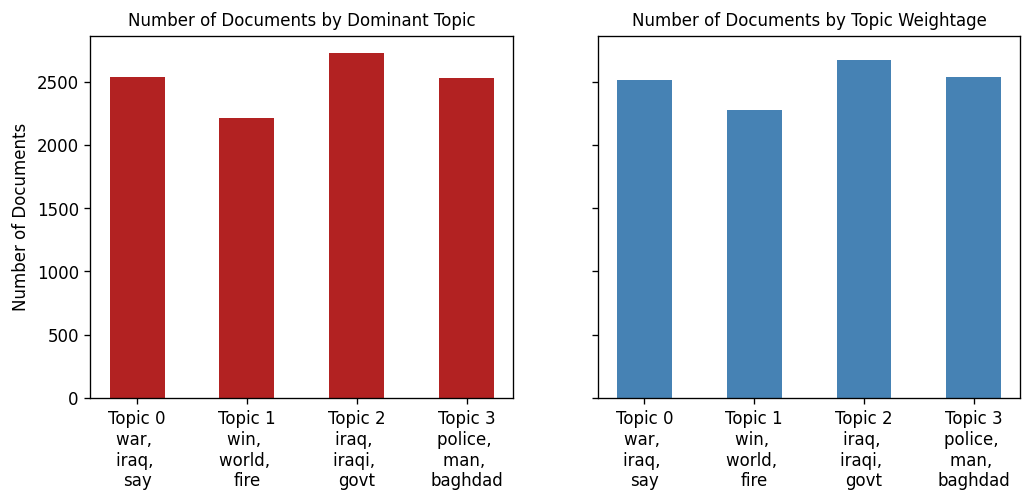

In [166]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [167]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9979 samples in 0.007s...
[t-SNE] Computed neighbors for 9979 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9979
[t-SNE] Computed conditional probabilities for sample 2000 / 9979
[t-SNE] Computed conditional probabilities for sample 3000 / 9979
[t-SNE] Computed conditional probabilities for sample 4000 / 9979
[t-SNE] Computed conditional probabilities for sample 5000 / 9979
[t-SNE] Computed conditional probabilities for sample 6000 / 9979
[t-SNE] Computed conditional probabilities for sample 7000 / 9979
[t-SNE] Computed conditional probabilities for sample 8000 / 9979
[t-SNE] Computed conditional probabilities for sample 9000 / 9979
[t-SNE] Computed conditional probabilities for sample 9979 / 9979
[t-SNE] Mean sigma: 0.000858


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.204159


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 0.728437


Loading BokehJS ...

#### Visualizes the results of LDA interactively

In [170]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.065519 -0.069522       1        1  26.879199
3      0.195560 -0.026378       2        1  25.363203
0     -0.092733 -0.075440       3        1  25.240721
1     -0.037308  0.171340       4        1  22.516877, topic_info=         Term        Freq       Total Category  logprob  loglift
275    police  253.000000  253.000000  Default  30.0000  30.0000
317       man  210.000000  210.000000  Default  29.0000  29.0000
43       iraq  415.000000  415.000000  Default  28.0000  28.0000
49        war  373.000000  373.000000  Default  27.0000  27.0000
3495  baghdad  165.000000  165.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
56       take   29.715282  100.784724   Topic4  -5.9571   0.2696
49        war   40.190983  373.008064   Topic4  -5.6551  -0.7371
572     first   25.980588   71.470300   Topic4  -6.0914   0.4790
11       call   26.036706  136.882060   Topic4  -6.0892  -0.1687
69      water   25.597680  108.373199   Topic4  -6.1062   0.0478

[282 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
285       3  0.955808    access
1084      2  0.990601  accident
1188      1  0.187946  adelaide
1188      4  0.789372  adelaide
646       4  0.983828       afl
...     ...       ...       ...
4481      3  0.943719   working
488       1  0.061017     world
488       2  0.026150     world
488       3  0.270217     world
488       4  0.645035     world

[493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

#### Wordcloud

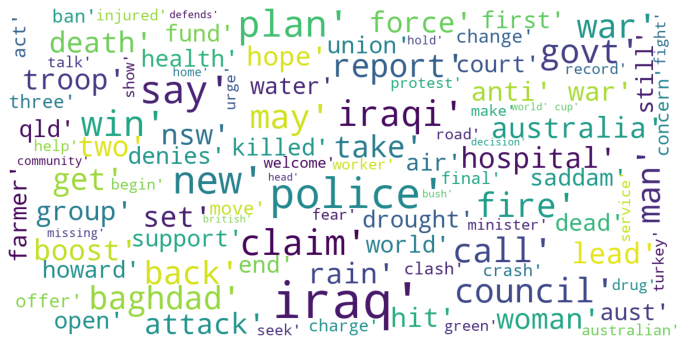

In [171]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [172]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

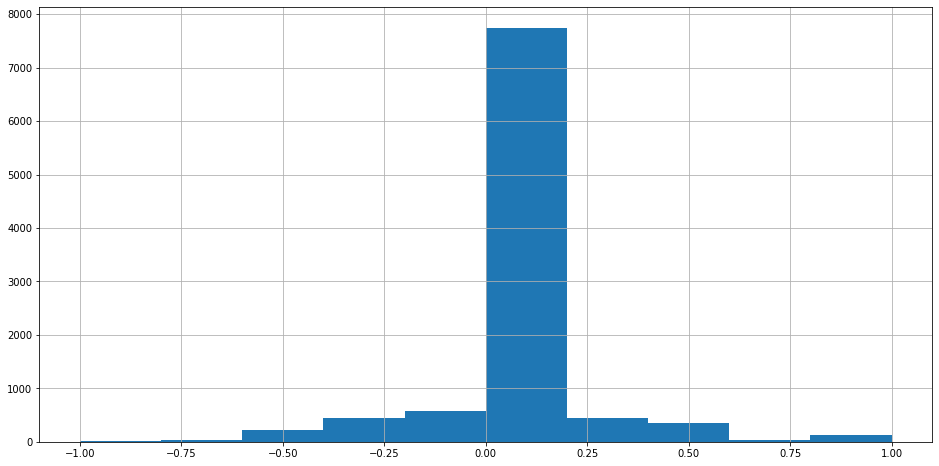

In [173]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

<BarContainer object of 3 artists>

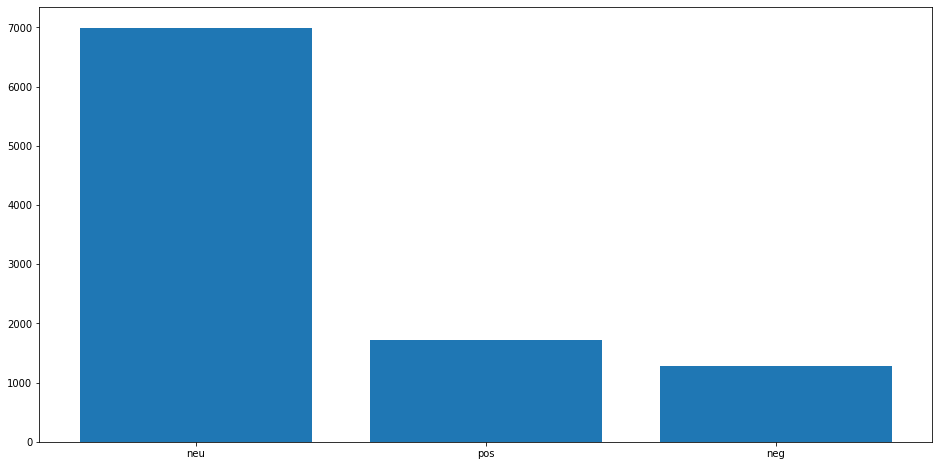

In [174]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [175]:
news[news['polarity'] == 'pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [176]:
news[news['polarity'] == 'neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

#### Vader Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rsouza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

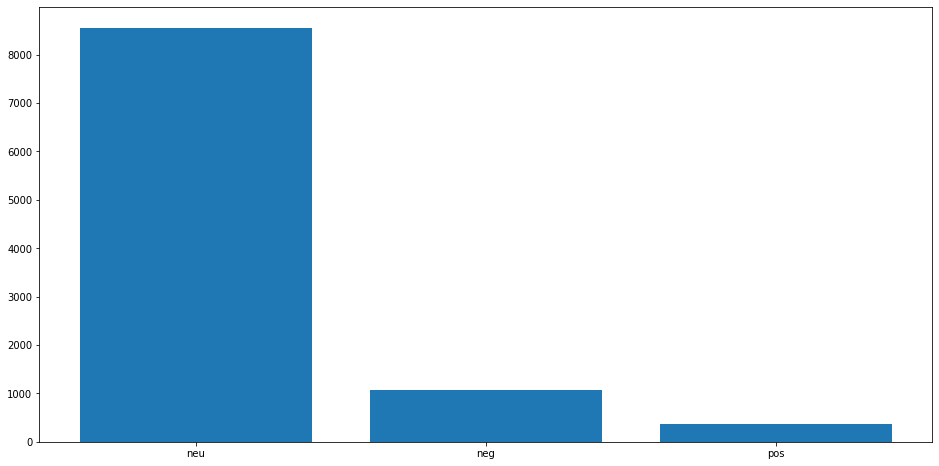

In [177]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [178]:
#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [179]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Chabahar', 'GPE'), ('Thursday', 'DATE')]

In [180]:
from spacy import displacy

displacy.render(doc, style='ent')

In [181]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

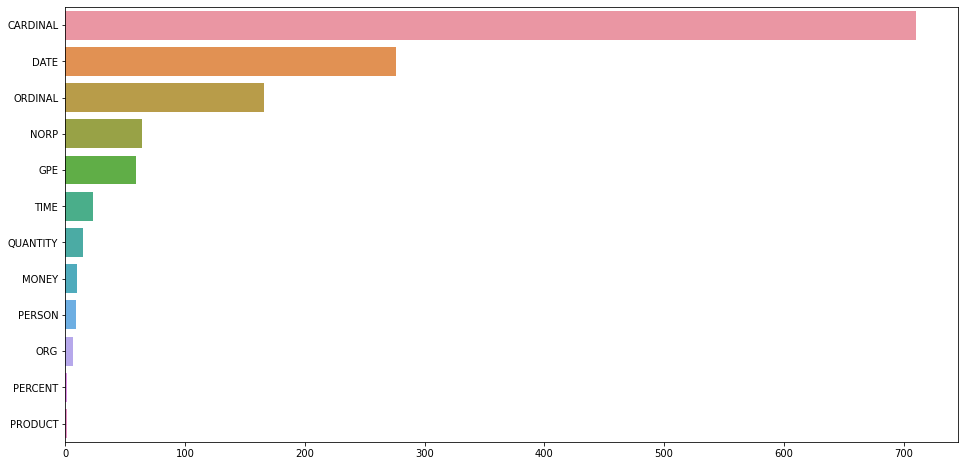

In [182]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common tokens per entity

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

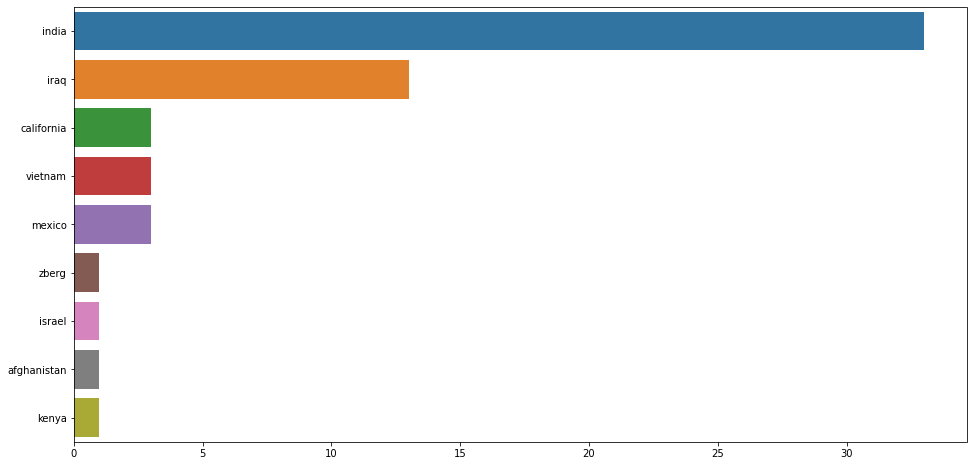

In [183]:
def ner(text,ent = "GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Most common names on News headlines

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

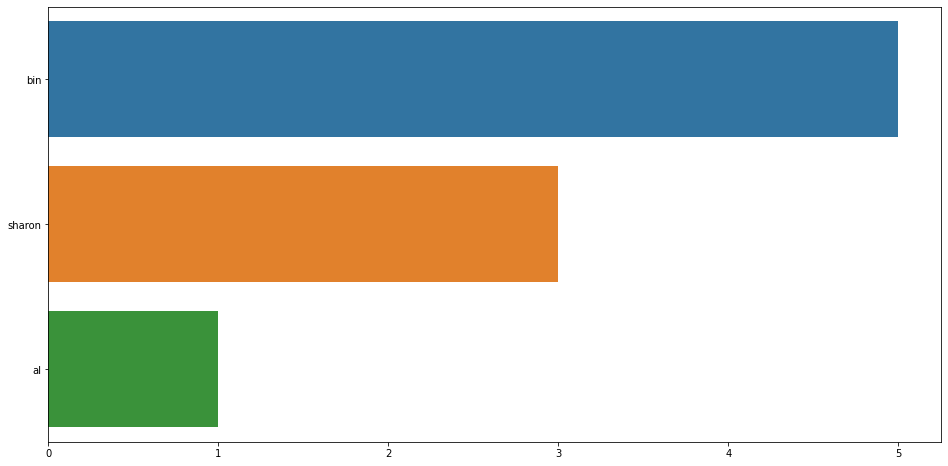

In [184]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Exploration through Parts of Speach Tagging in python

In [185]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [186]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

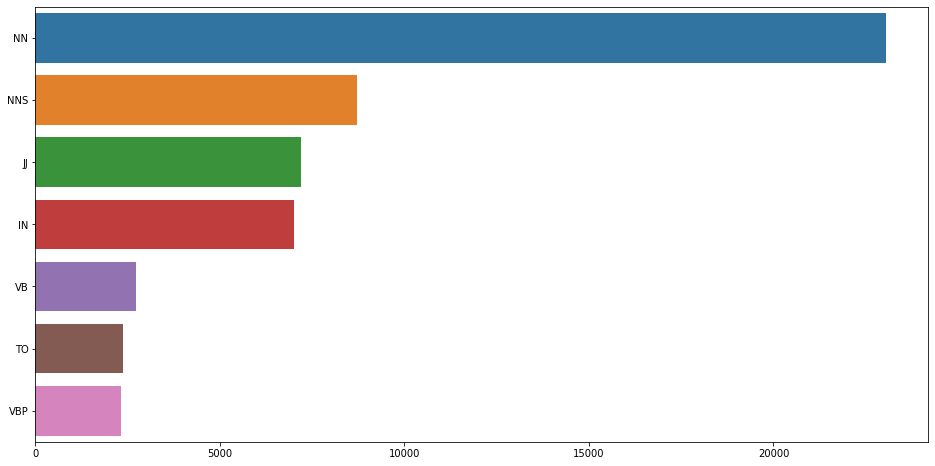

In [187]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.p

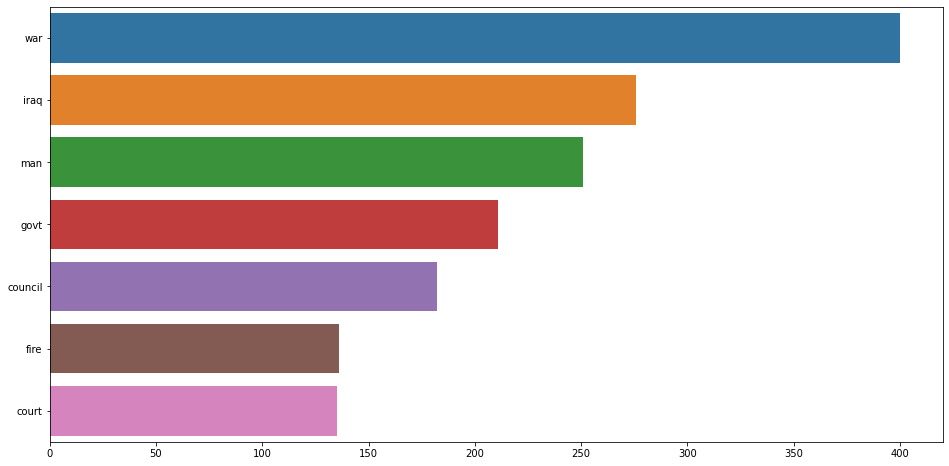

In [188]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

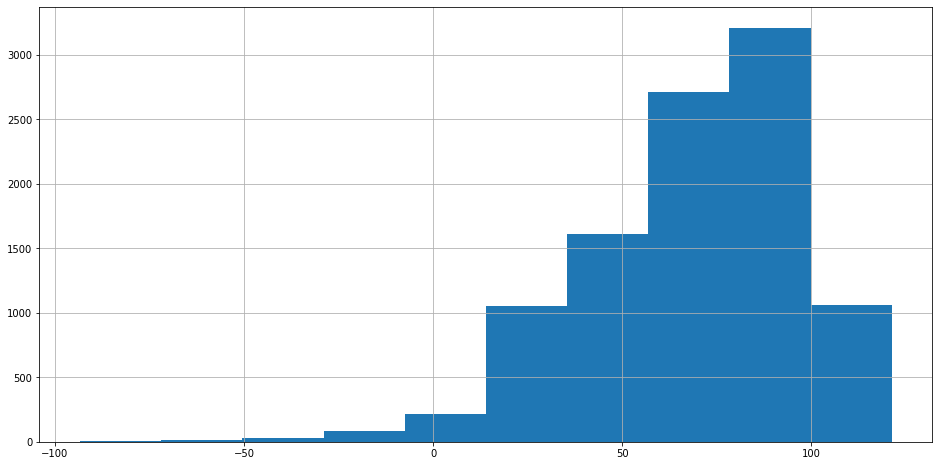

In [189]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [190]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()

134    policewomen accusations feature at federal crime
150      report highlights container terminal potential
285       groups praise outgoing opposition agriculture
298            investigations underway into qantas skid
308      landholder contribution still under discussion
Name: headline_text, dtype: object